In [1]:
import numpy as np # NumPy
import matplotlib.pylab as plt # Matplotlib plots
import matplotlib.patches as mpatches
import pandas as pd # Pandas
import uproot
import pickle

# import awkward as ak
# import mplhep as hep
# import argparse     # to get arguments from command line executing file.py
import os # read directories etc.
from scipy.signal import find_peaks, gaussian
from scipy.optimize import curve_fit
from scipy.stats import gaussian_kde
import pylandau
# import re
# import copy

import time
from timeout_decorator import timeout

from LoadBatch import *

verbose = False
debug = False

In [2]:
pd.set_option('display.max_columns', None)
# plt.rcParams['text.usetex'] = True   ### LateX in matplotlib
# !ls ../Data_TestBeam/2023_May/

In [3]:
# plt.style.use(hep.atlas.style.ATLAS)

### Generic bins options, sensors and runs import

In [4]:
PIXEL_SIZE = 0.0185 #mm

### choose the bins so that they match the MIMOSA pixels (which are just the coordinates)
large_bins = (np.arange(0, 900,1),
              np.arange(0, 600,1))

bins = (np.arange(450, 700, 1),
        np.arange(150, 500, 1))

small_bins = (np.arange(500, 650, 1),
              np.arange(200, 450, 1))

### Load the dictionary of sensor names and runs
sensors_list = read_pickle("sensors_list.pickle")
dict_of_runs = read_pickle("dict_of_runs.pickle")
if verbose: 
    print(sensors_list)
    print(dict_of_runs)

### branches to be loaded (+ unnecessary columns)
branches = ["eventNumber", "Xtr", "Ytr", "pulseHeight", "charge", "timeCFD20", "timeCFD50", "timeCFD70"]
columns_to_remove = ["Xtr_4","Xtr_5","Xtr_6","Xtr_7","Ytr_4","Ytr_5","Ytr_6","Ytr_7"]

# sensors_on_four_ch = 
# sensors_on_one_ch = 

### I need the transimpedance for all the batches, channels
(now moved into LoadBatch.py)

In [2]:
# ### pretty ugly but no alternatives right now
# def get_transimpedance(batch, oscilloscope):
#     four_ch = 10700
#     single_ch = 4700
#     none = -1
#     if batch>=100 and batch<200:     ### Ch2      Ch3       Ch4
#         if oscilloscope=="S1":   return (four_ch, four_ch, four_ch)
#         elif oscilloscope=="S2": return (single_ch, single_ch, four_ch)
#     elif batch>=200 and batch<300:
#         if oscilloscope=="S1":   return (four_ch, four_ch, none)
#         elif oscilloscope=="S2": return (none, none, none)
#     elif batch>=300 and batch<400:
#         if oscilloscope=="S1":   return (four_ch, four_ch, single_ch)
#         elif oscilloscope=="S2": return (single_ch, single_ch, four_ch)
#     elif batch>=400 and batch<500:
#         if oscilloscope=="S1":   return (four_ch, four_ch, four_ch)
#         elif oscilloscope=="S2": return (single_ch, single_ch, single_ch)
#     elif batch>=500 and batch<600:
#         if oscilloscope=="S1":   return (single_ch, single_ch, single_ch)
#         elif oscilloscope=="S2": return (single_ch, single_ch, single_ch)
#     elif batch>=600 and batch<700:
#         if oscilloscope=="S1":   return (four_ch, four_ch, four_ch)
#         elif oscilloscope=="S2": return (single_ch, single_ch, four_ch)
#     elif batch>=700 and batch<800:
#         if oscilloscope=="S1":   return (four_ch, four_ch, four_ch)
#         elif oscilloscope=="S2": return (none, none, four_ch)
#     elif batch>=800 and batch<900:
#         if oscilloscope=="S1":   return (none, none, none)
#         elif oscilloscope=="S2": return (single_ch, single_ch, none)
#     elif batch>=900 and batch<1000:
#         if oscilloscope=="S1":   return (single_ch, single_ch, none)
#         elif oscilloscope=="S2": return (none, none, none)
#     elif batch>=1000 and batch<1100:
#         if oscilloscope=="S1":   return (four_ch, four_ch, four_ch)
#         elif oscilloscope=="S2": return (single_ch, single_ch, four_ch)
#     elif batch>=1100 and batch<1200:
#         if oscilloscope=="S1":   return (single_ch, single_ch, none)
#         elif oscilloscope=="S2": return (single_ch, single_ch, none)
#     elif batch>=1200 and batch<1300:
#         if oscilloscope=="S1":   return (single_ch, single_ch, none)
#         elif oscilloscope=="S2": return (none, none, none)
#     elif batch>=1300 and batch<1400:
#         if oscilloscope=="S1":   return (none, none, none)
#         elif oscilloscope=="S2": return (none, single_ch, none)
#     else:     ### last case, return all none
#         if oscilloscope=="S1":   return (none, none, none)
#         elif oscilloscope=="S2": return (none, none, none)

## Plot a single batch

Batch:  410
S1


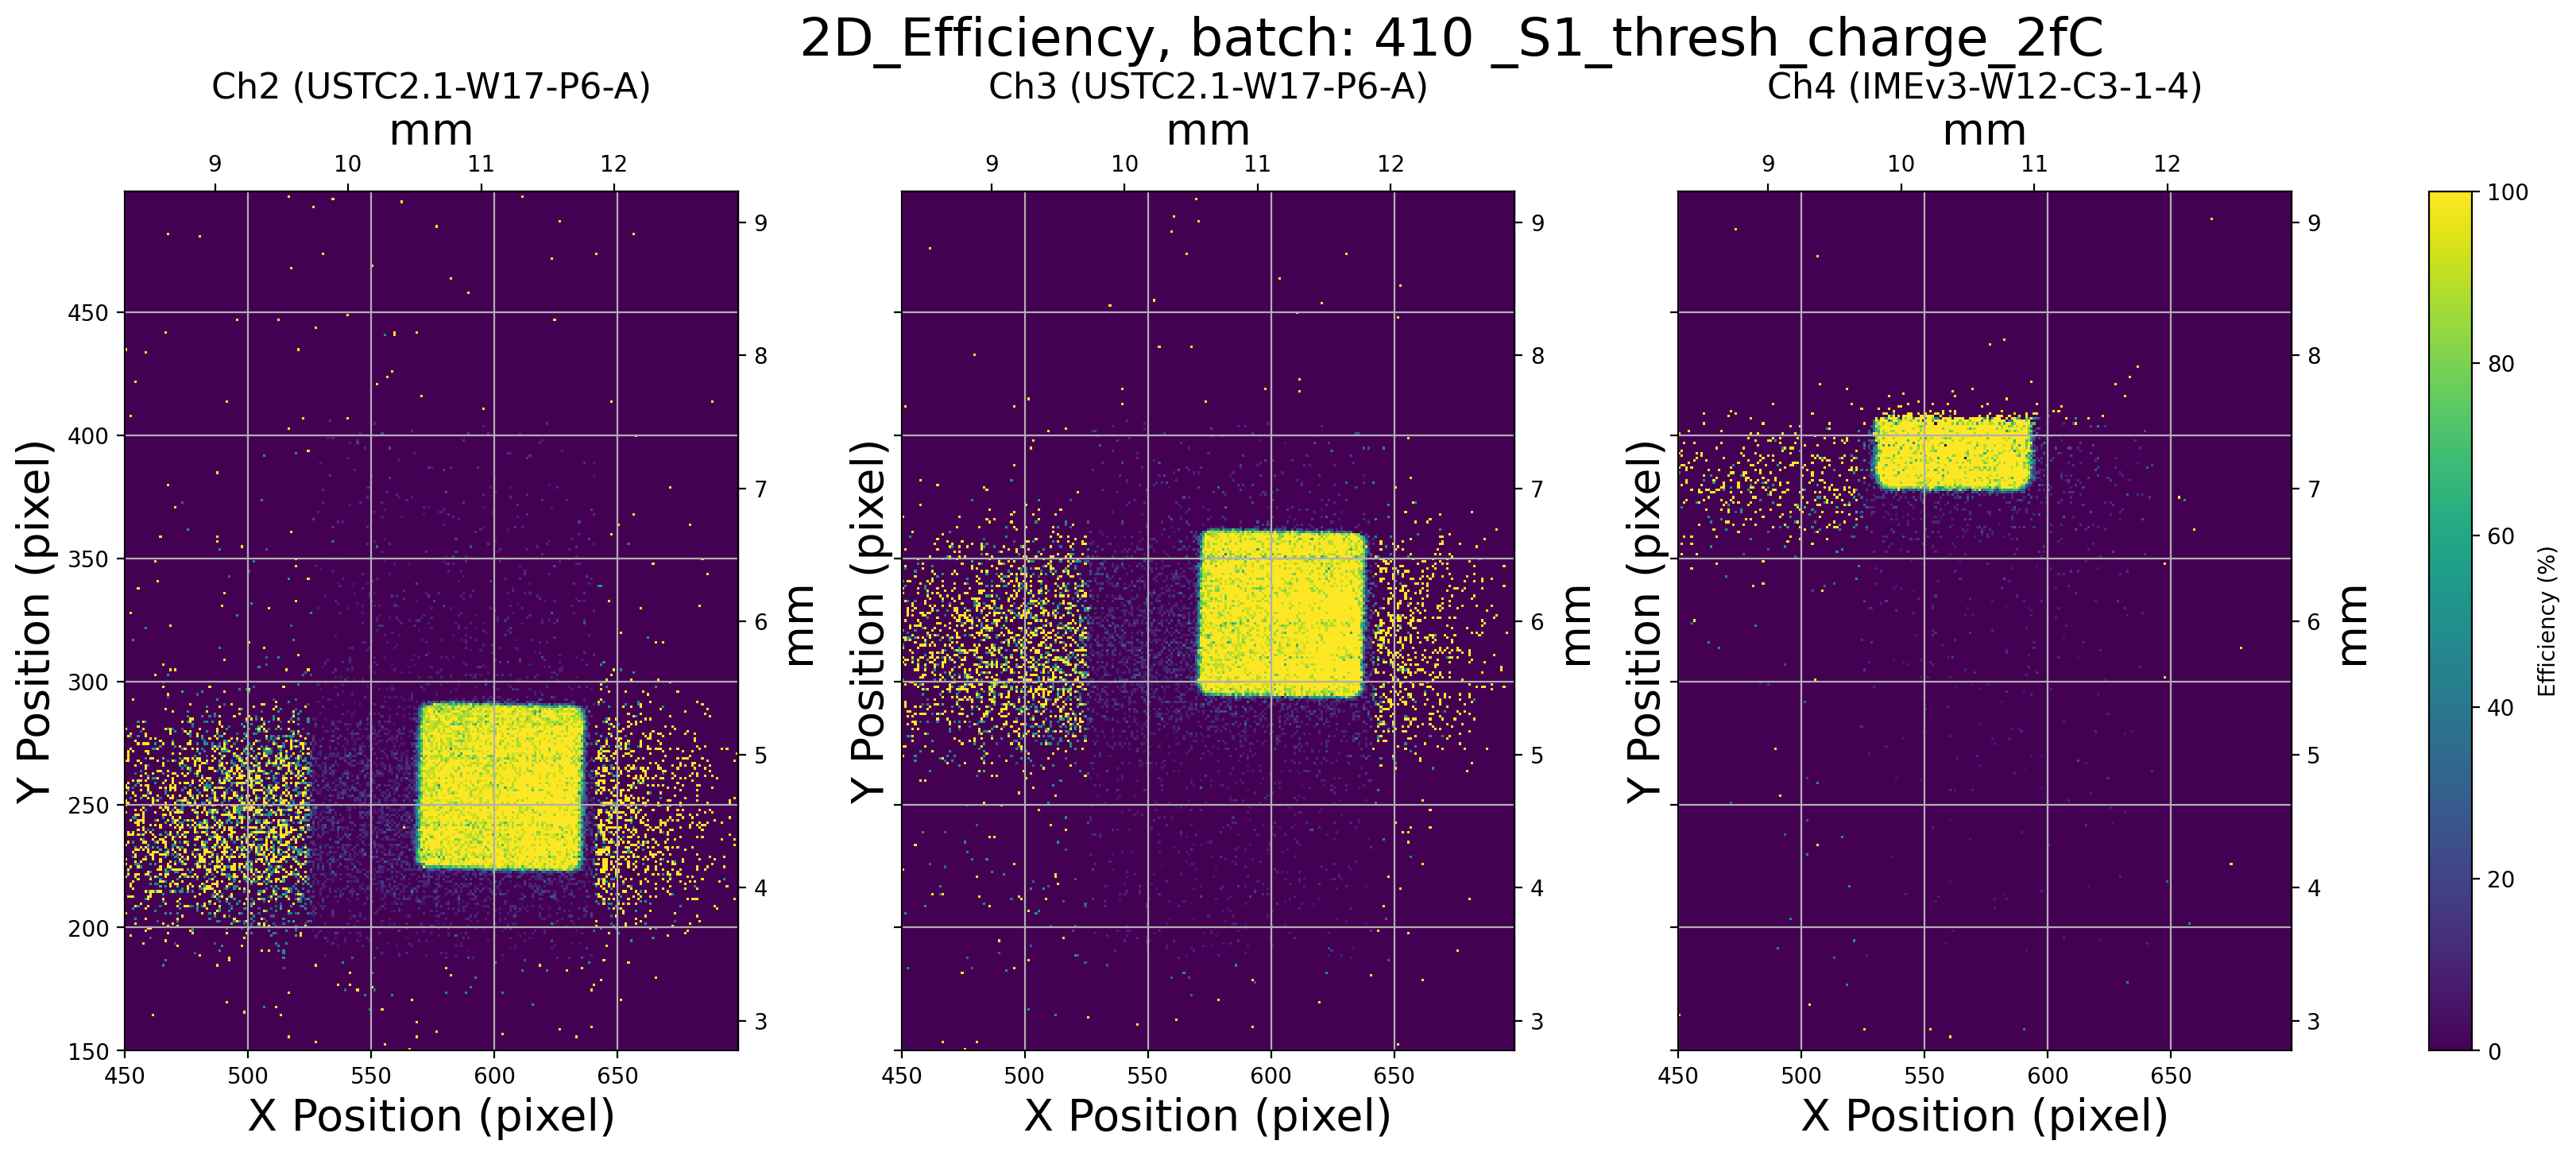

S2


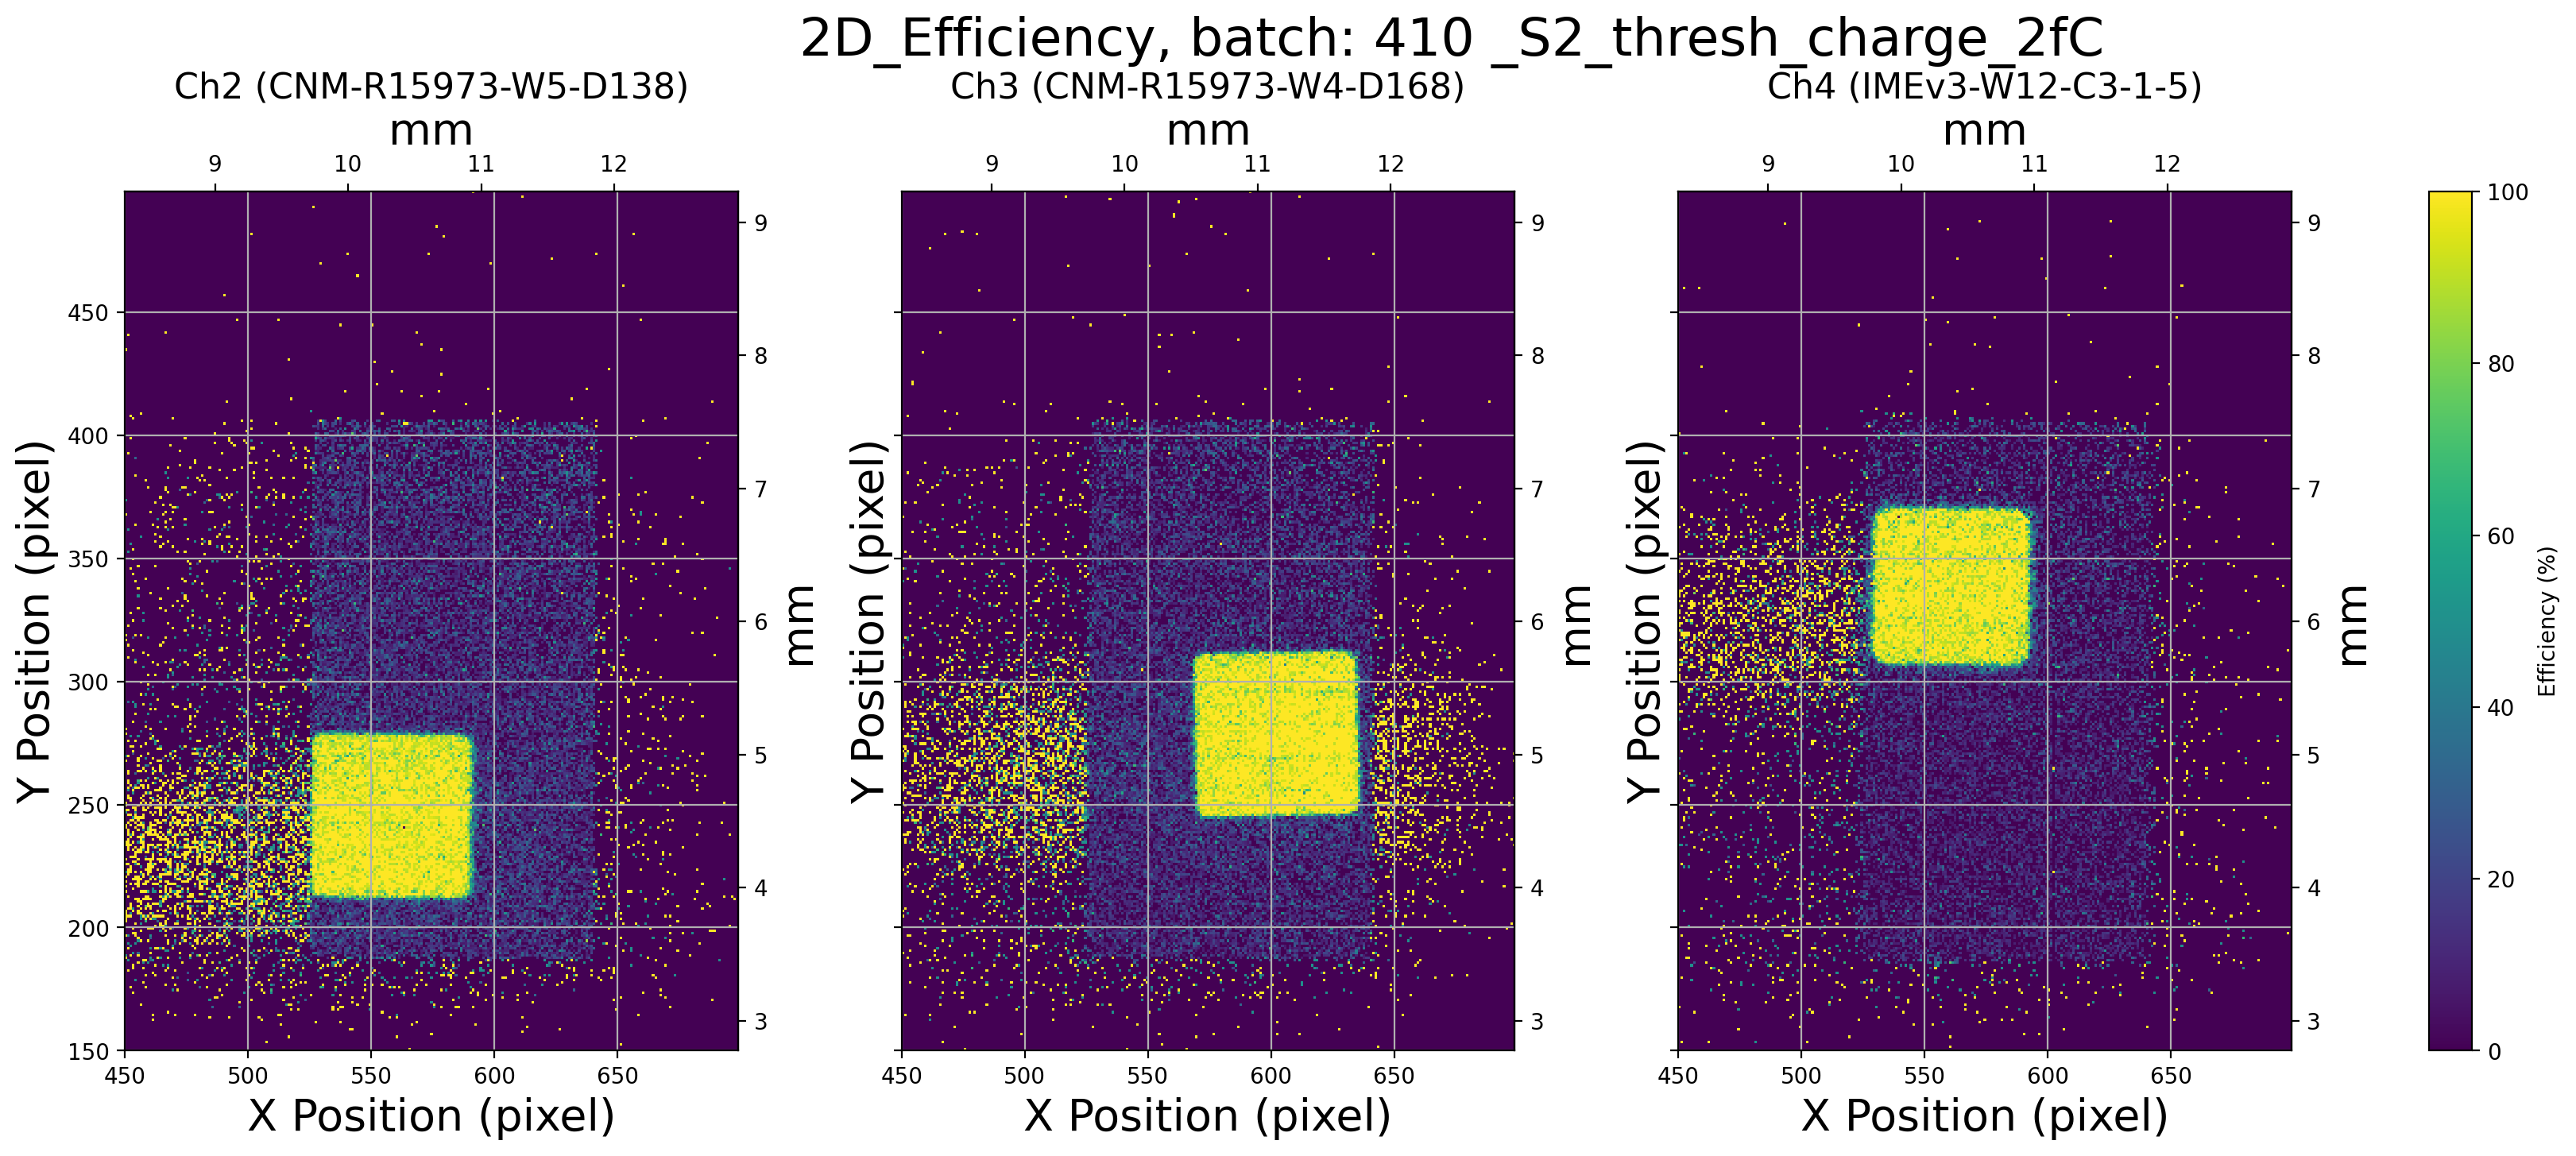

In [8]:
threshold_charge = 2 #fC

this_batch = 410
print("Batch: ", this_batch)
dir_path = {} 
df = {}  # dictionary containing the two dataframes of the two oscilloscopes
binning_method = 'rice'
for S in ["S1","S2"]: # the two scopes
    print(S)
    dir_path[S] = f"../Data_TestBeam/2023_May/{S}/"
    file_path = f"tree_May2023_{S}_{this_batch}.root"    
    df[S] = root_to_df(os.path.join(dir_path[S], file_path), branches)
    df[S] = df[S].drop(columns=columns_to_remove)
    transimpedance = get_transimpedance(this_batch,S)
#     plot(df[S], "1D_Tracks", batch=this_batch, sensors=sensors_list[this_batch][S], bins=large_bins,
#      savefig=False, savefig_details=f'_{S}')
#     plot(df[S], "2D_Sensors", this_batch, sensors=sensors_list[this_batch][S], bins=small_bins, bins_find_min=method,
#     savefig=False, savefig_details=f'_{S}_{method}_large_bins')
#     fig, axes = plot(df[S], "1D_Efficiency", batch=this_batch, sensors=sensors_list[this_batch][S], transimpedance=transimpedance, threshold_charge=2, no_geometry_cut=False,
#                     bins=large_bins, bins_find_min=method, savefig=False, savefig_details=f'_{S}_threshold_charge_{threshold_charge}fC_large_bins')
    plot(df[S], "2D_Efficiency", batch=this_batch, sensors=sensors_list[this_batch][S], transimpedance=transimpedance, threshold_charge=threshold_charge, no_geometry_cut=True,
                    bins=bins, bins_find_min=binning_method, n_DUT=[1,2,3], savefig=False, savefig_details=f'_{S}_thresh_charge_{threshold_charge}fC')
    #     savefig=True, savefig_details='_S2')

In [7]:
# fig

## PLOT ALL BATCHES (might be slow, can be done in parts)

In [8]:
threshold_charge = 2 

### SAVE THE PLOTS FOR ALL BATCHES
binning_method = 'rice'
RUN_ALL_BATCHES = False  ### so I don't accidentally run this
if RUN_ALL_BATCHES:
    for S in ["S1","S2"]: ### the two scopes
        if S=="S2": continue
        for this_batch in np.sort(list(dict_of_runs[S].keys())):  ### I sort them so I can restart from the batch I want
            if this_batch>=0:# and this_batch<=500:
                print("Batch: ", this_batch)
                dir_path = f"../Data_TestBeam/2023_May/{S}/"
                file_path = f"tree_May2023_{S}_{this_batch}.root"    
                try:
                    df = root_to_df(os.path.join(dir_path, file_path), branches)
                except:
                    print("something wrong reading the file")
                    continue
                df = df.drop(columns=columns_to_remove)
                transimpedance = get_transimpedance(this_batch, S)
        #         plot(df,"2D_Tracks", batch=this_batch, sensors=sensors_list[this_batch][S], bins=bins,
        #              savefig=True, savefig_details=f'_{S}')
    #             plot(df,"1D_Tracks", batch=this_batch, sensors=sensors_list[this_batch][S], bins=large_bins,
    #                  savefig=True, savefig_details=f'_{S}')
        #         bins = 1000
        #         plot(df, "pulseHeight", batch=this_batch, sensors=sensors_list[this_batch][S], bins=bins,
        #             savefig=True, savefig_details=f"_{S}_bins_{bins}")
#                 plot(df, '2D_Sensors', batch=this_batch, sensors=sensors_list[this_batch][S],
#                      bins=large_bins, bins_find_min=binning_method, savefig=False, savefig_details=f'_{S}_large_bins')#_{binning_method}')
#                 plot(df, "1D_Efficiency", batch=this_batch, sensors=sensors_list[this_batch][S], transimpedance=transimpedance, threshold_charge=threshold_charge, no_geometry_cut=False,
#                     bins=large_bins, bins_find_min=binning_method, savefig=True, savefig_details=f'_{S}_threshold_charge_{threshold_charge}fC_large_bins')
                plot(df, "2D_Efficiency", batch=this_batch, sensors=sensors_list[this_batch][S], transimpedance=transimpedance, threshold_charge=threshold_charge, no_geometry_cut=True,
                    bins=large_bins, bins_find_min=binning_method, savefig=True, savefig_details=f'_{S}_thresh_charge_{threshold_charge}fC_large_bins')
            ### I think something is leaking memory!!!
            plt.close('all') ### I think this worked. maybe not actually


## Plot a single run

In [9]:
# ### looking at single runs 
# dir_path = f"../Data_TestBeam/2023_May/S1/"
# run = 9723
# file_path = f"tree00{run}.root"    
# df_run = root_to_df(os.path.join(dir_path, file_path), branches)
# df_run = df_run.drop(columns=columns_to_remove)
    
# plot(df_run,"2D_Tracks", batch=this_batch, sensors=sensors_list[this_batch]["S1"], bins=bins,
#     savefig=True, savefig_details=f"_single_run_{run}")
# # plot(df["S2"],"2D_Tracks", batch=this_batch, sensors=sensors_list[this_batch]["S2"], bins=bins)

## Improved efficiency study

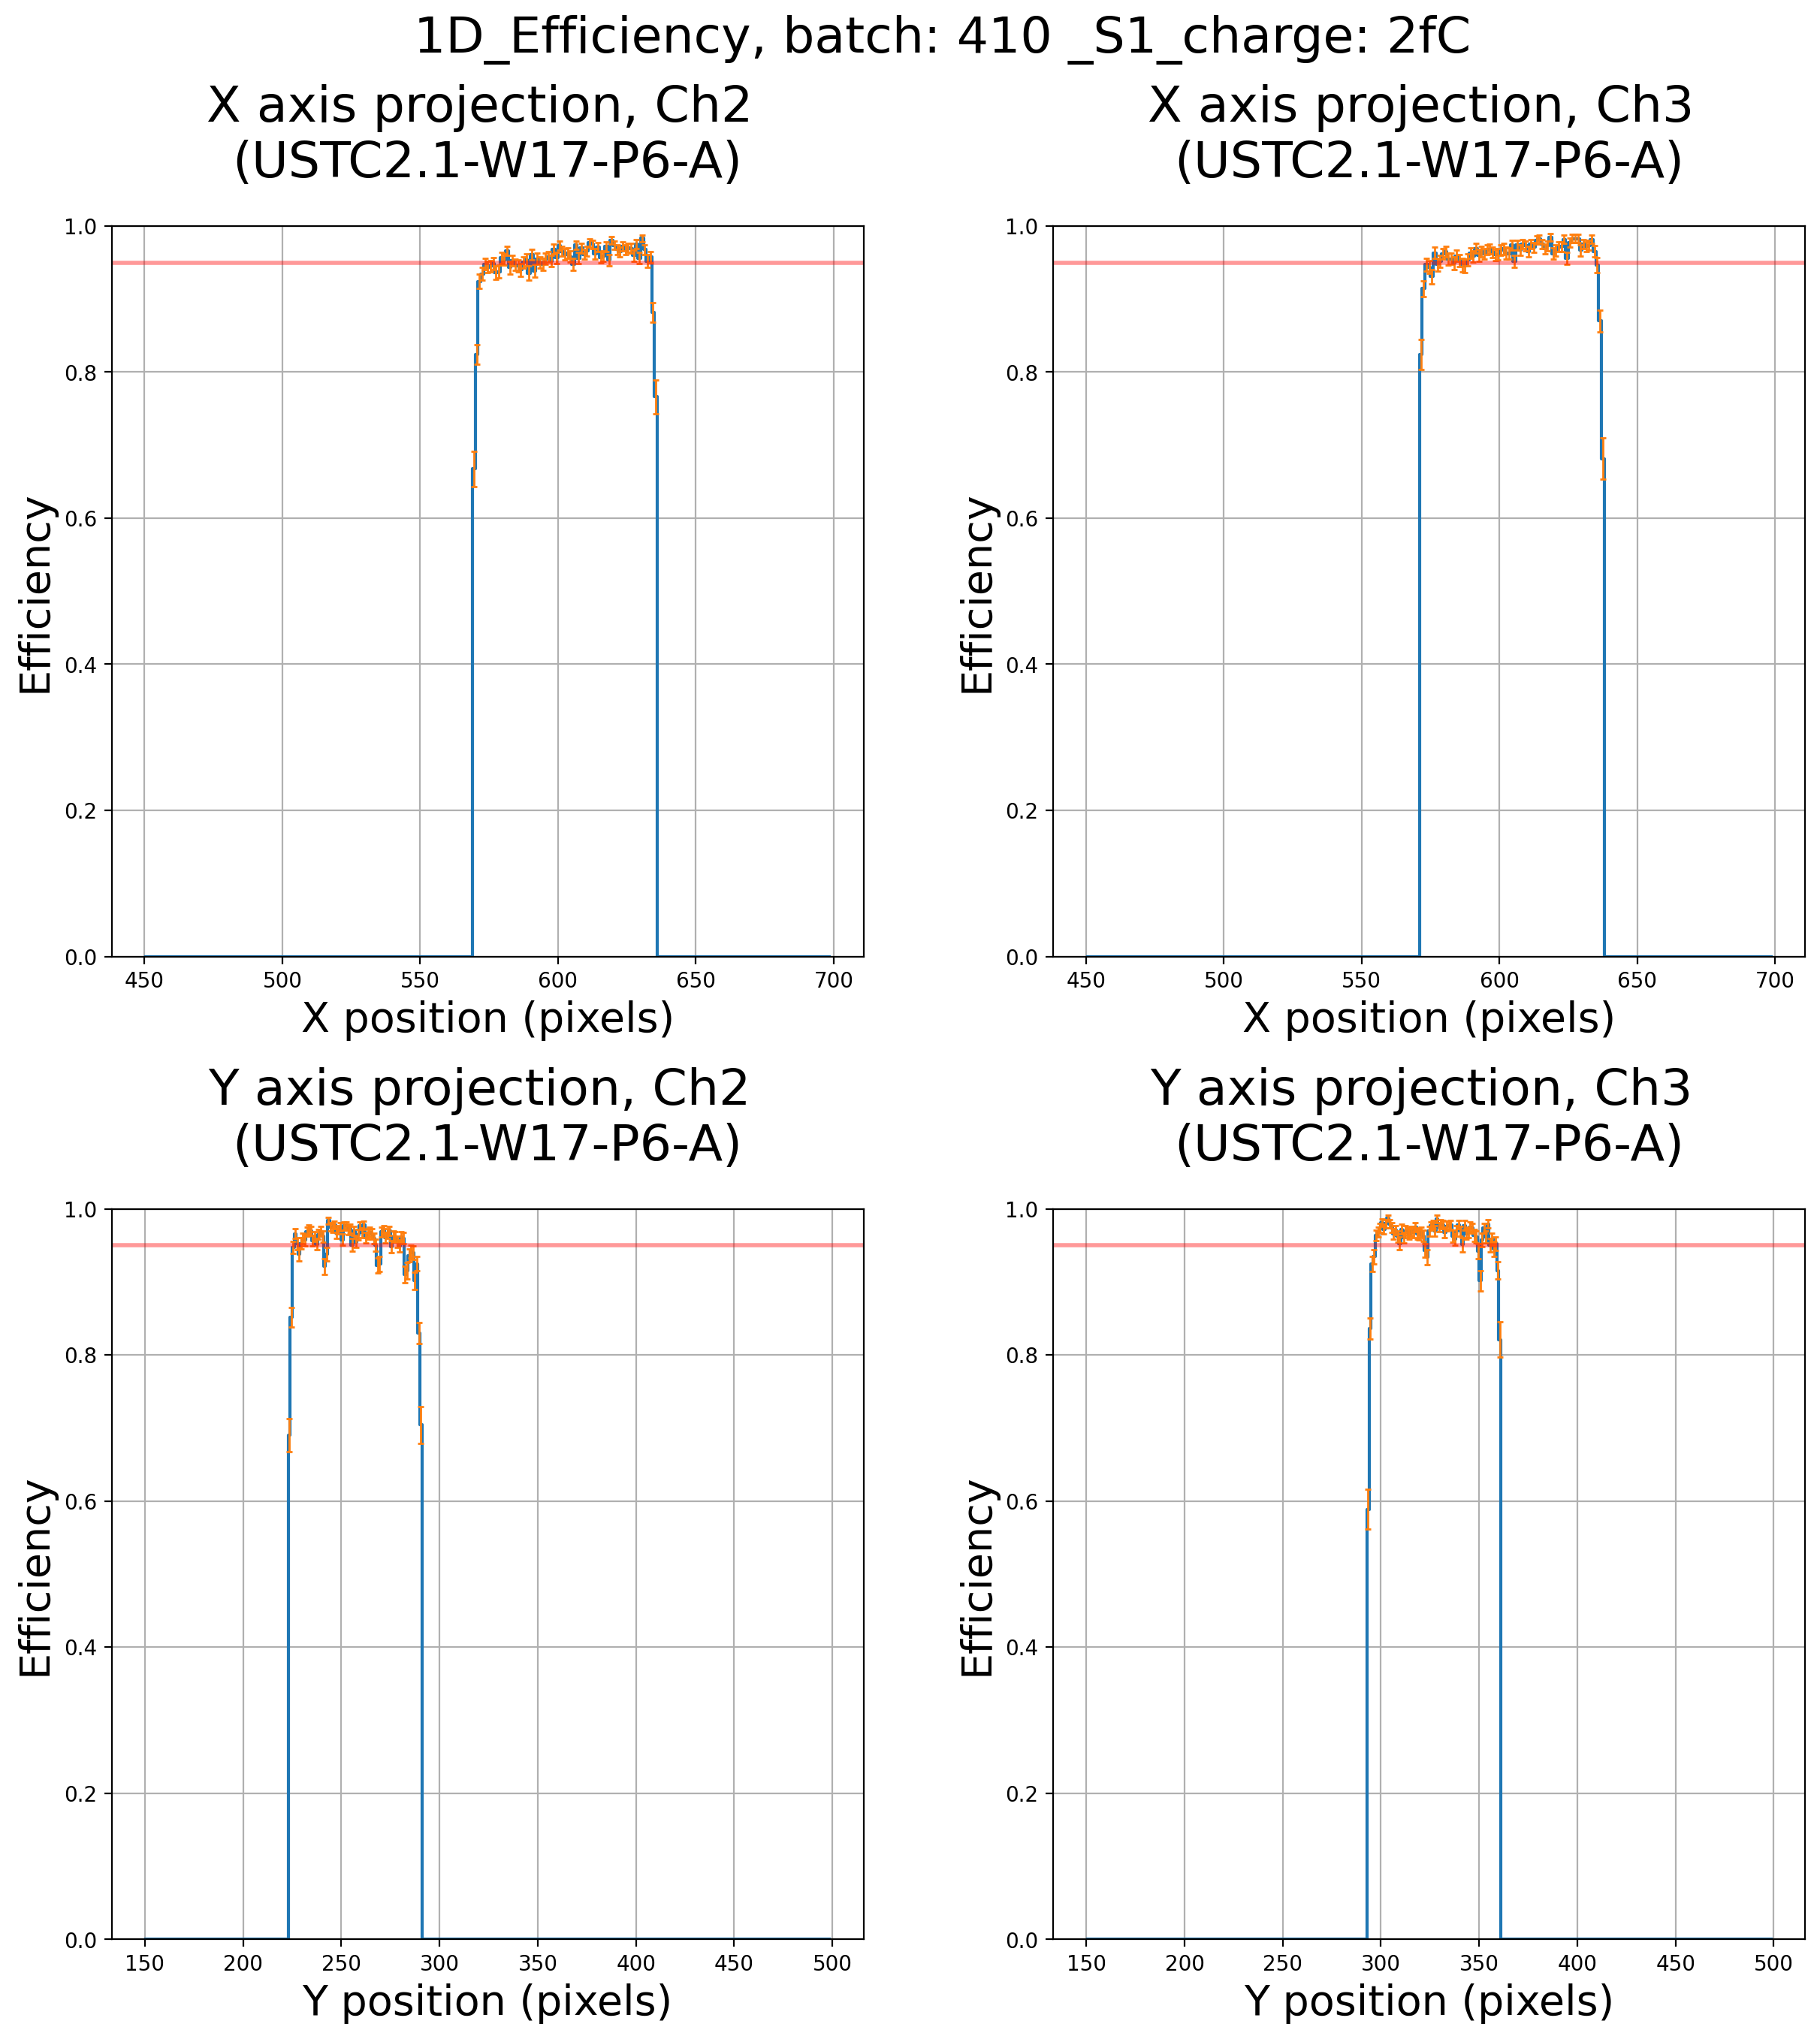

In [9]:
this_scope = "S1"
fig, axes = plot(df[this_scope], "1D_Efficiency", this_batch, bins=bins, no_geometry_cut=False, n_DUT=[1,2],
                 threshold_charge=2, transimpedance=transimpedance, sensors=sensors_list[this_batch][this_scope],
                 savefig=False, savefig_details=f'_{this_scope}_charge: 2fC')

# for ax in axes.flatten():
#     ax.grid('--')
#     ax.axhline(0.95, label="95% efficiency", color='r', alpha=0.4, linewidth=2)
#     ax.legend(fontsize=16)
fig
# fig.savefig("../various plots/1D_Efficiency_410_S1_charge: 2fC.jpg")

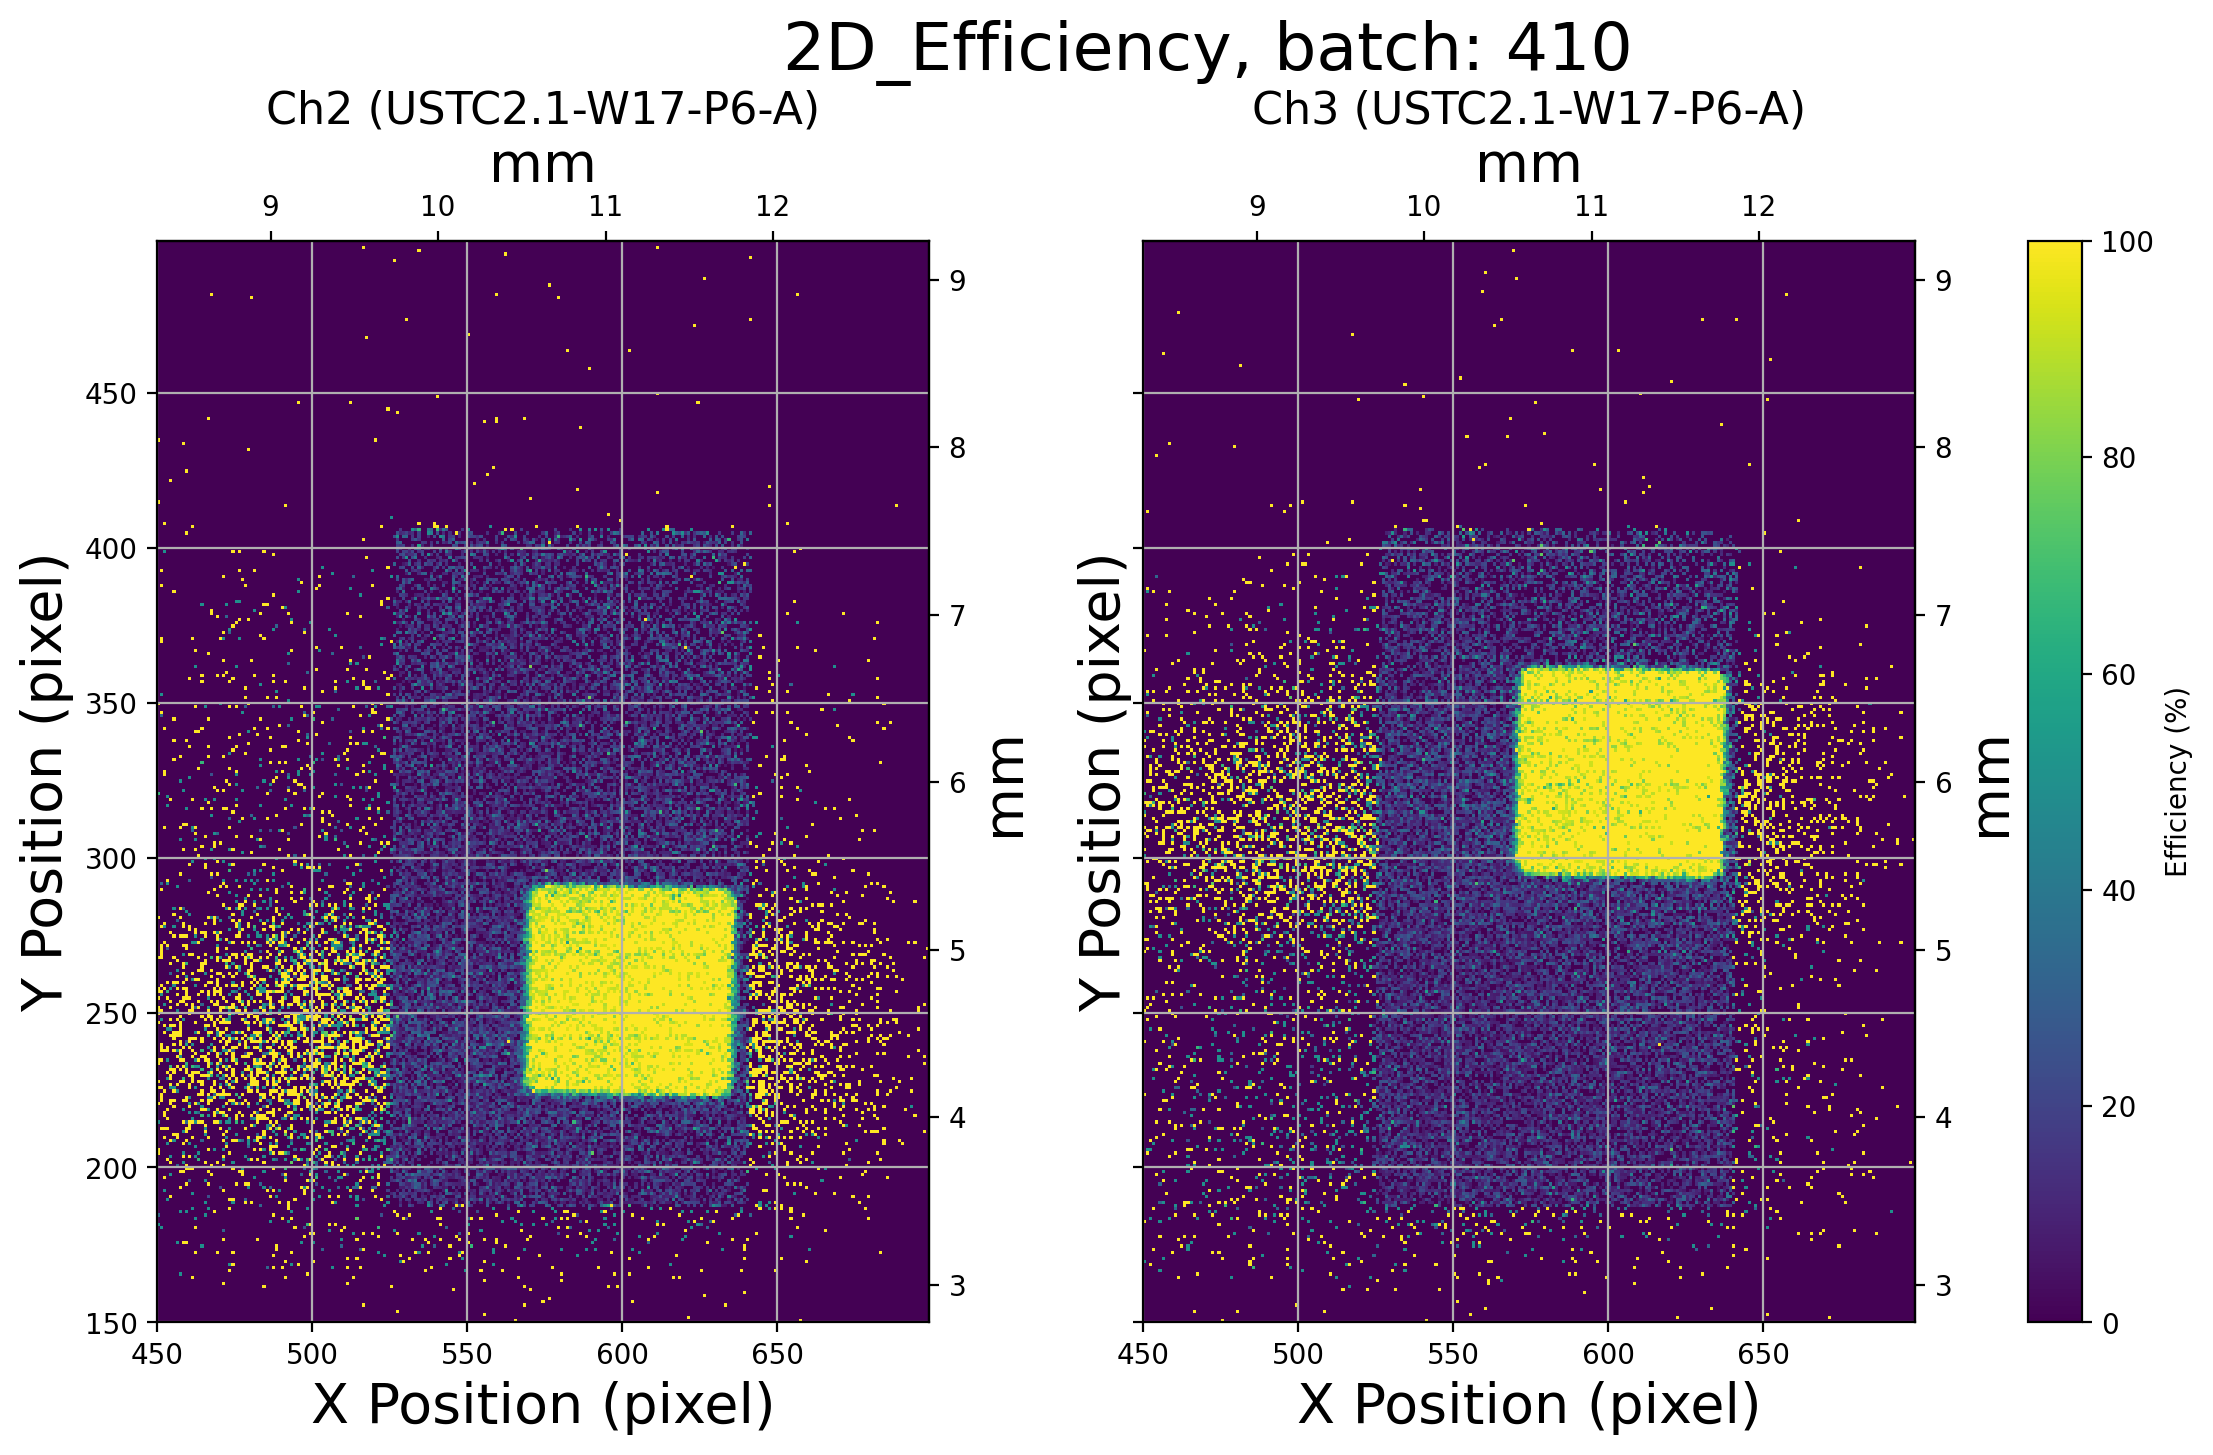

In [11]:
fig, axes = plot(df[this_scope], "2D_Efficiency", this_batch, bins=bins, no_geometry_cut=True, n_DUT=[1,2], sensors=sensors_list[this_batch][this_scope],
                 threshold_charge=2, transimpedance=transimpedance, savefig=False)

In [13]:
# fig 

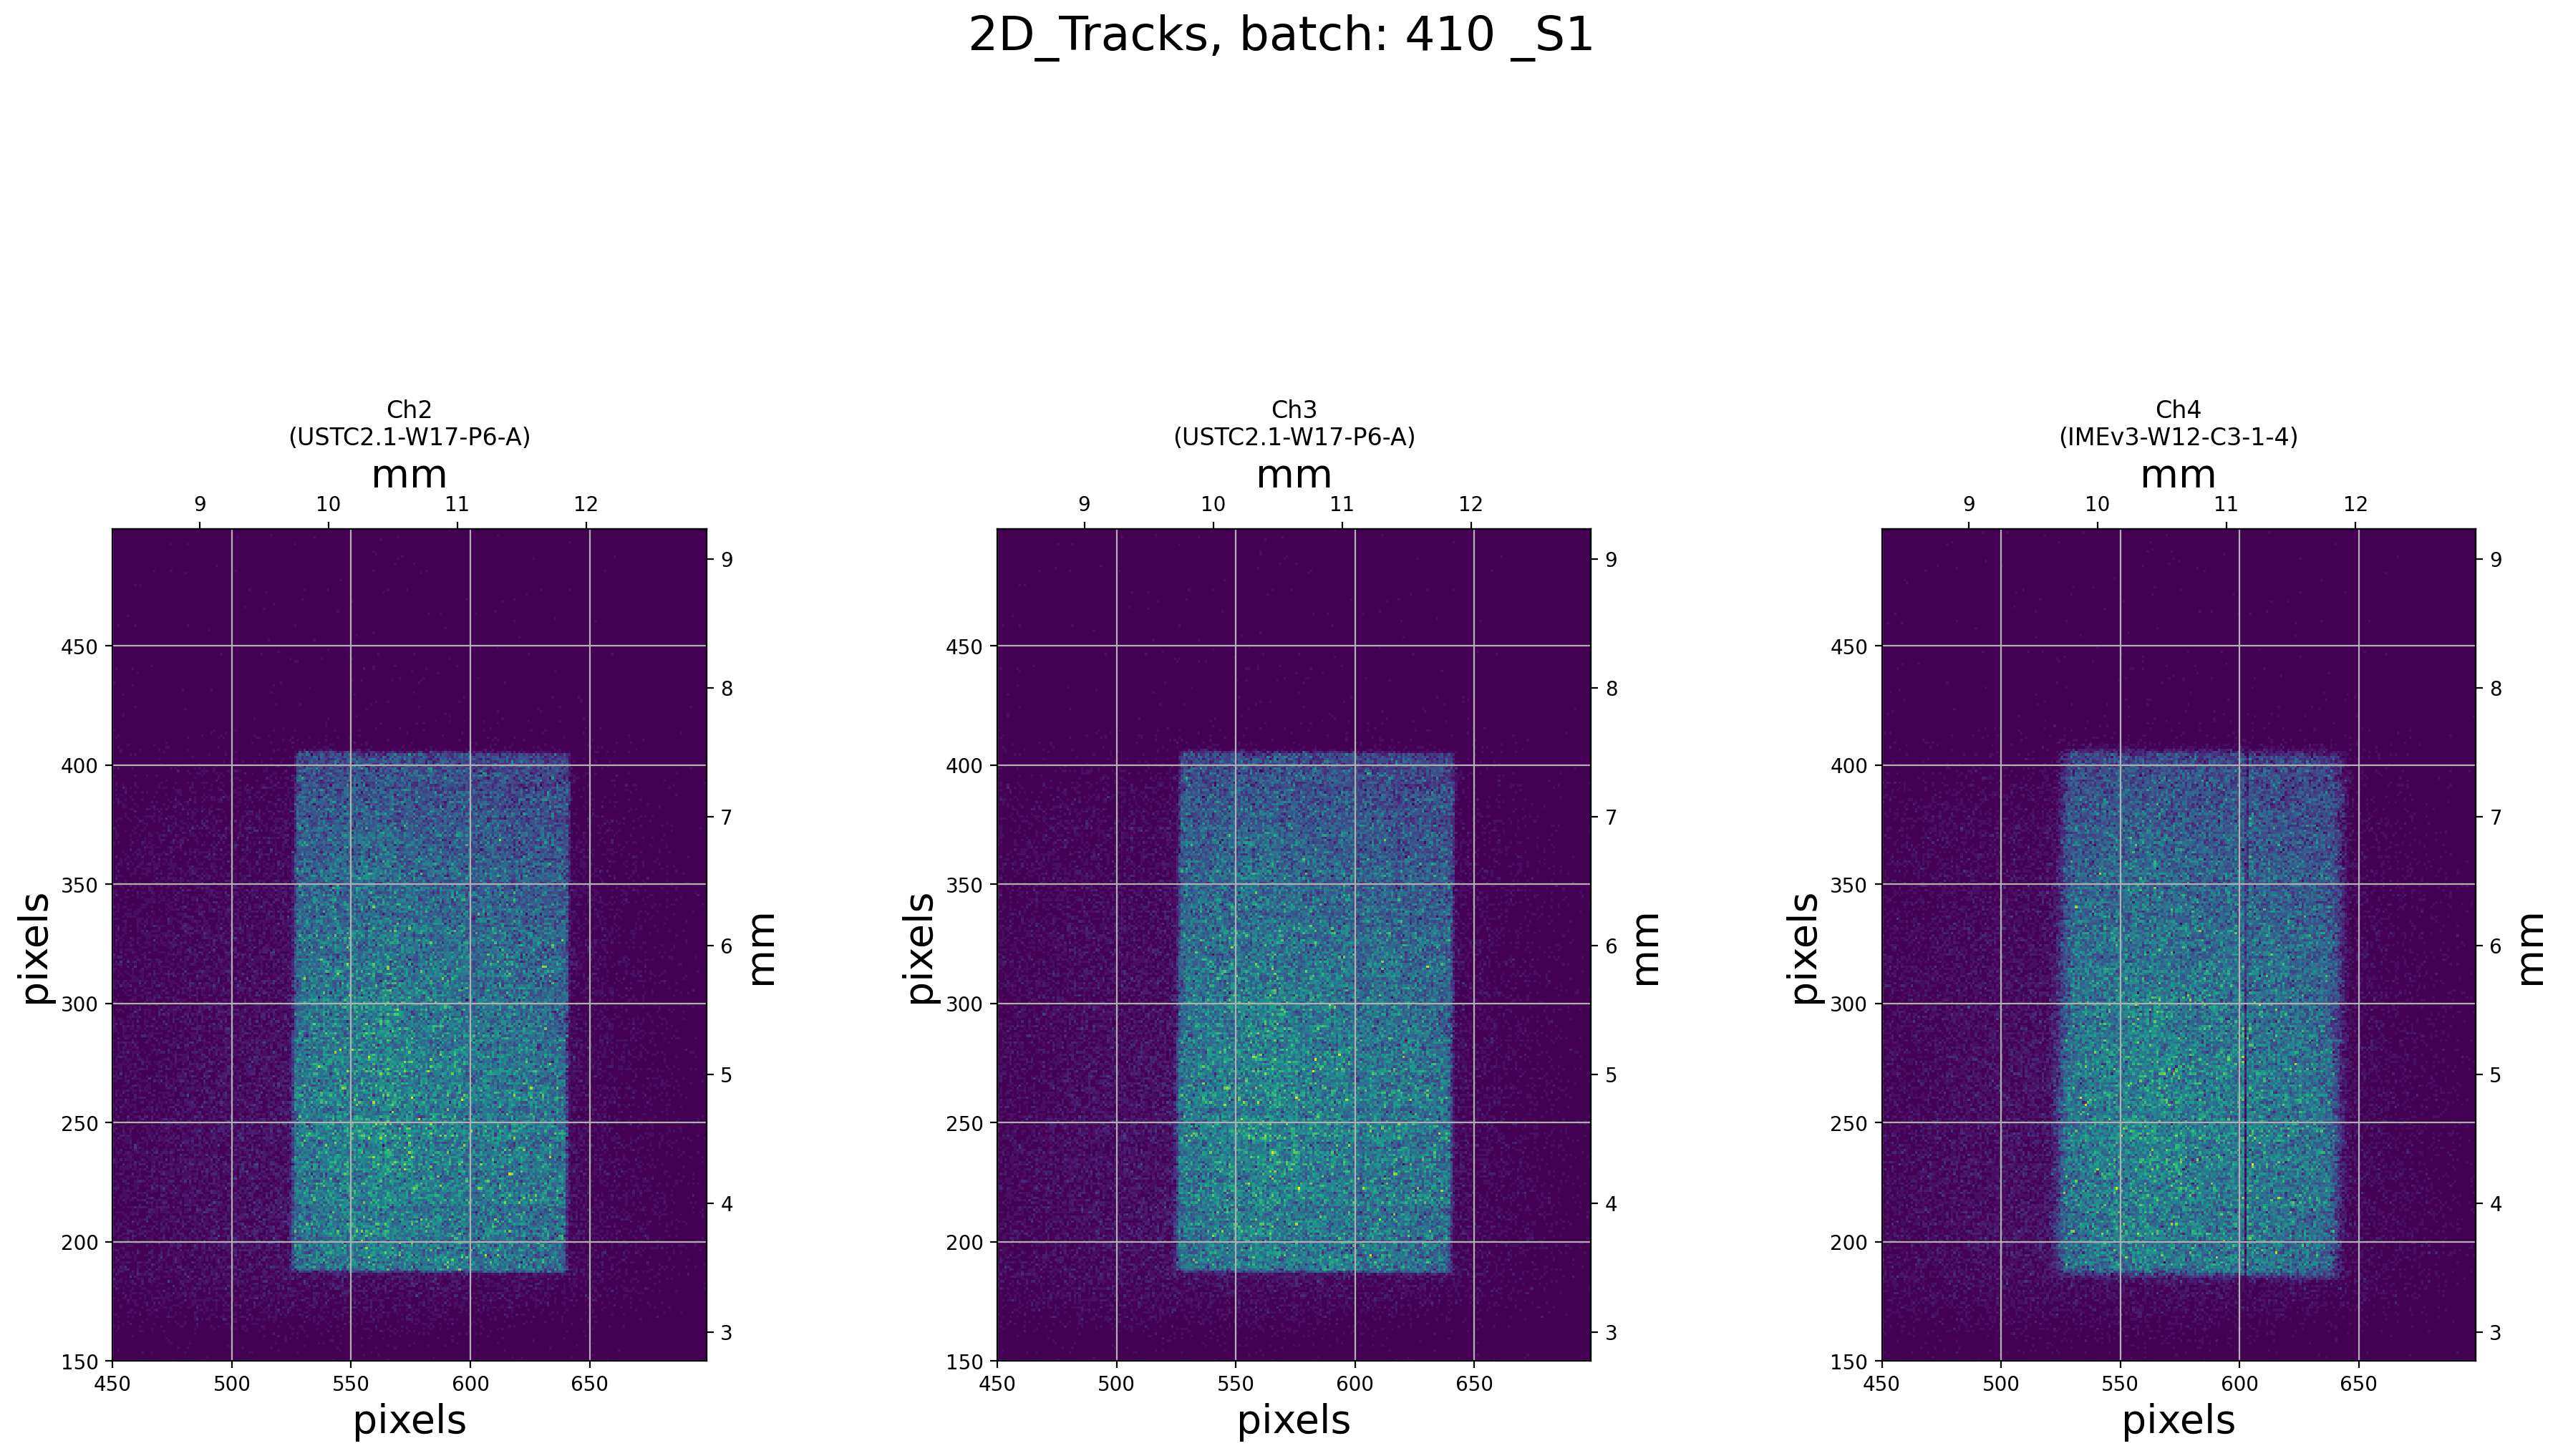

(<Figure size 3600x2000 with 3 Axes>,
 array([<AxesSubplot:title={'center':'Ch2\n(USTC2.1-W17-P6-A)'}, xlabel='pixels', ylabel='pixels'>,
        <AxesSubplot:title={'center':'Ch3\n(USTC2.1-W17-P6-A)'}, xlabel='pixels', ylabel='pixels'>,
        <AxesSubplot:title={'center':'Ch4\n(IMEv3-W12-C3-1-4)'}, xlabel='pixels', ylabel='pixels'>],
       dtype=object))

In [12]:
S = "S1"
plot(df[S],"2D_Tracks", batch=this_batch, sensors=sensors_list[this_batch][S], bins=bins,
     savefig=False, savefig_details=f'_{S}')

In [12]:
# left_edge, right_edge = find_edges(Xtr_1cut)

# fig, ax = plt.subplots(figsize=(15,8))
# hist, bins, _ = plt.hist(Xtr_1cut, bins=bins[0], histtype='step')#, label=f'Xtr sensor: {these_sensors[1]}')
# ax.plot((bins[:-1]+bins[1:])/2, np.gradient(hist), label='gradient of Xtr')
# ax.axvline(left_edge, color='g', linestyle='--', label='left edge')
# ax.axvline(right_edge, color='r', linestyle='--', label='right edge')
# # ax.set_title(f"Xtr_1 distribution of {these_sensors[1]} (with pulseheight cut)", fontsize=24, y=1.05)
# ax.set_xlim(400,900)
# ax.set_xlabel("Position (pixels)", fontsize=20)
# ax.set_ylabel("Events", fontsize=20)
# ax.grid('--')
# ax.legend(fontsize=20, loc='upper left')

# # fig.savefig(f"../various plots/locating_edges_Xtr_of_{these_sensors[1]}.jpg")

## Calculate all minimums (for this batch)

In [13]:
mins = {}
for S in ["S1","S2"]:
    mins[S] = [find_min_btw_peaks(df[S][f"pulseHeight_{i}"], bins='rice', plot=False) for i in range(1,4)]
    mins[S].insert(0,None)     ### insert None as the 'peak' of the MCP

In [14]:

sensors_list[this_batch][this_scope]['Ch2']

'USTC2.1-W17-P6-A'

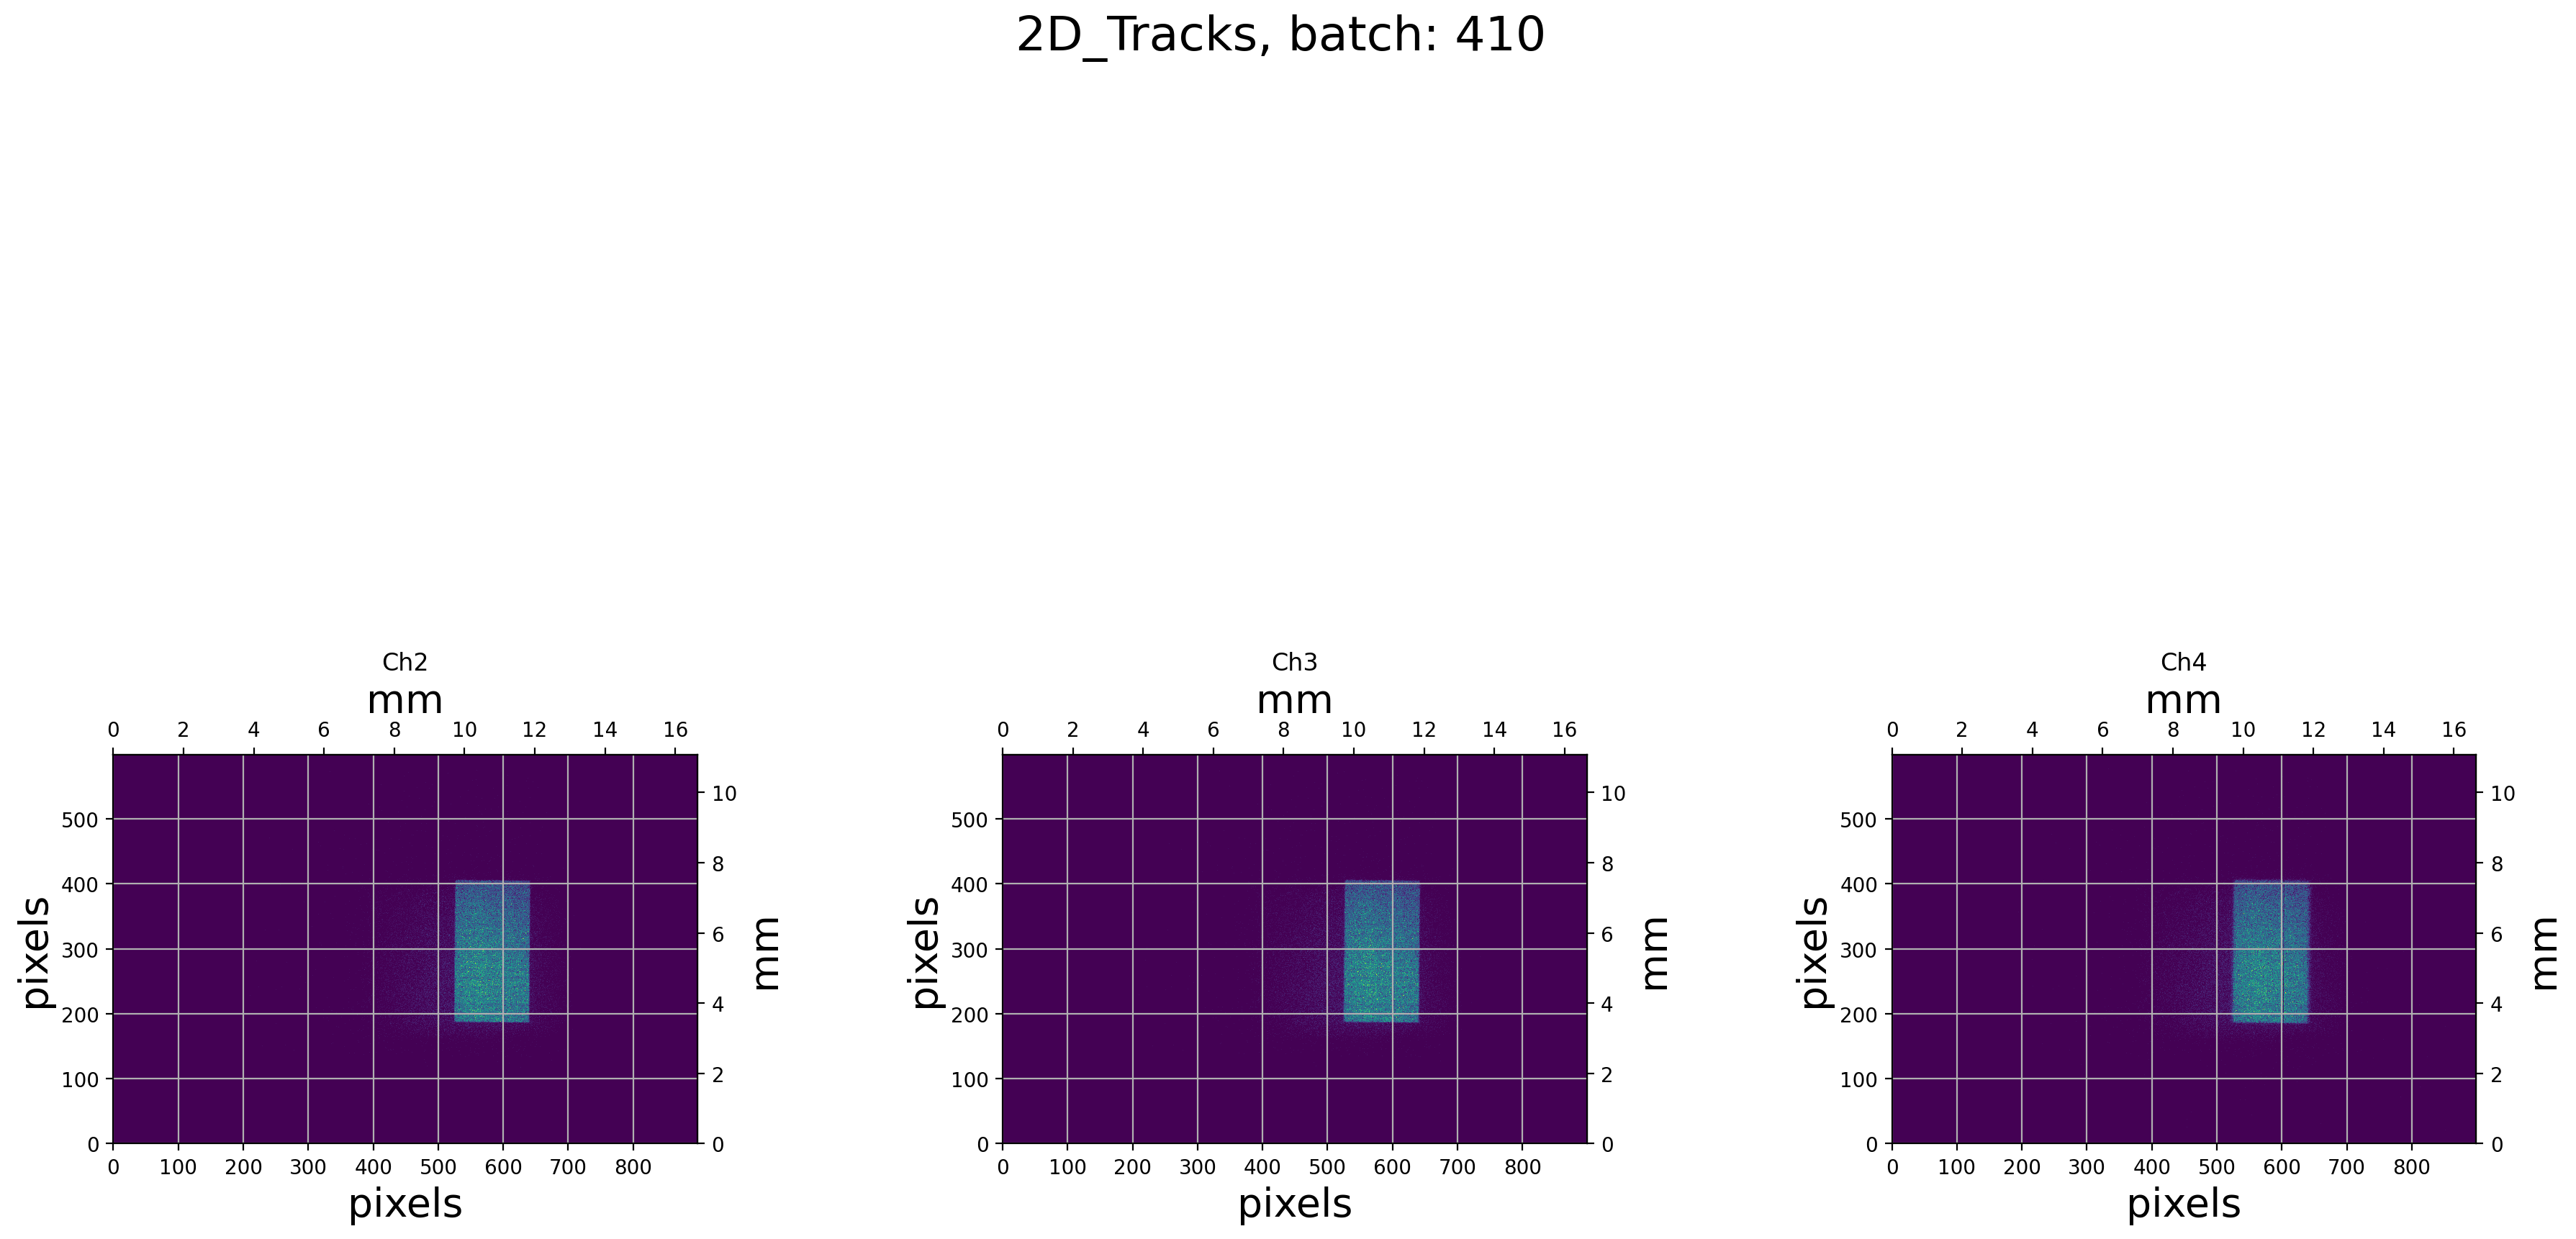

Text(0.5, 0.95, '2D_Tracks, batch: 410')

In [15]:
fig, ax = plot(df["S1"], "2D_Tracks",batch=this_batch, bins=large_bins)
fig.suptitle("2D_Tracks, batch: 410", y=0.95)
# fig

## Efficiency Study

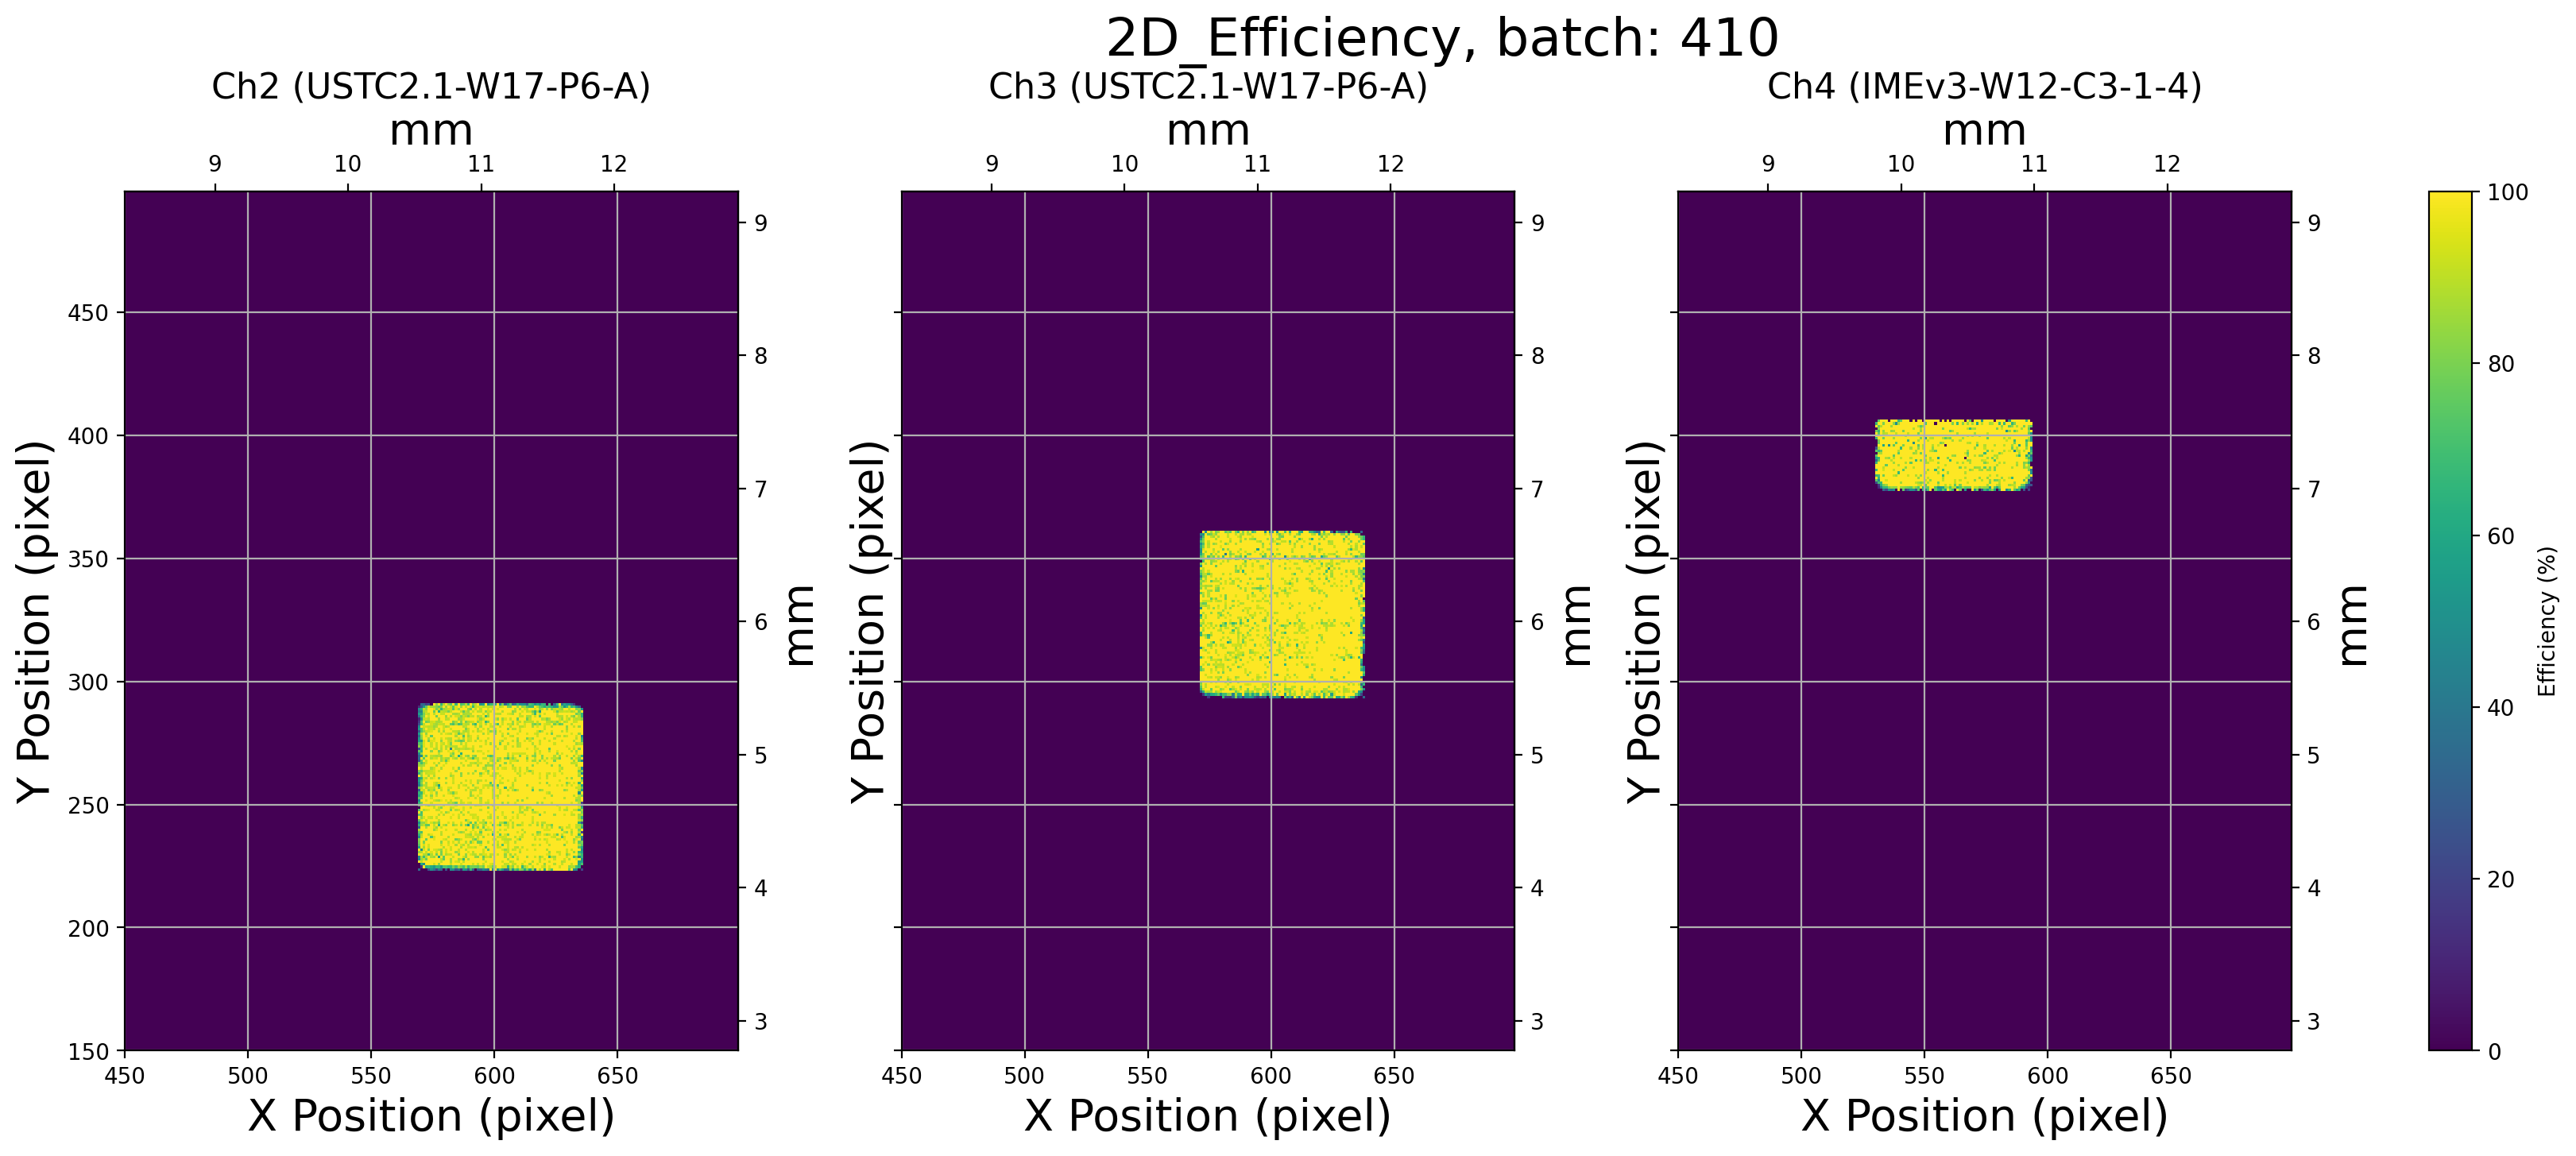

In [16]:
### efficiency study
threshold_charge = 2 #fC
transimpedance = get_transimpedance(this_batch, this_scope) 

fig,axes = plot(df[this_scope], "2D_Efficiency", this_batch, bins=bins, no_geometry_cut=False,
                sensors=sensors_list[this_batch][this_scope], threshold_charge=threshold_charge, transimpedance=transimpedance,
               savefig=False)
fig

## plotting where the noise is
aka where pulseHeight<mins

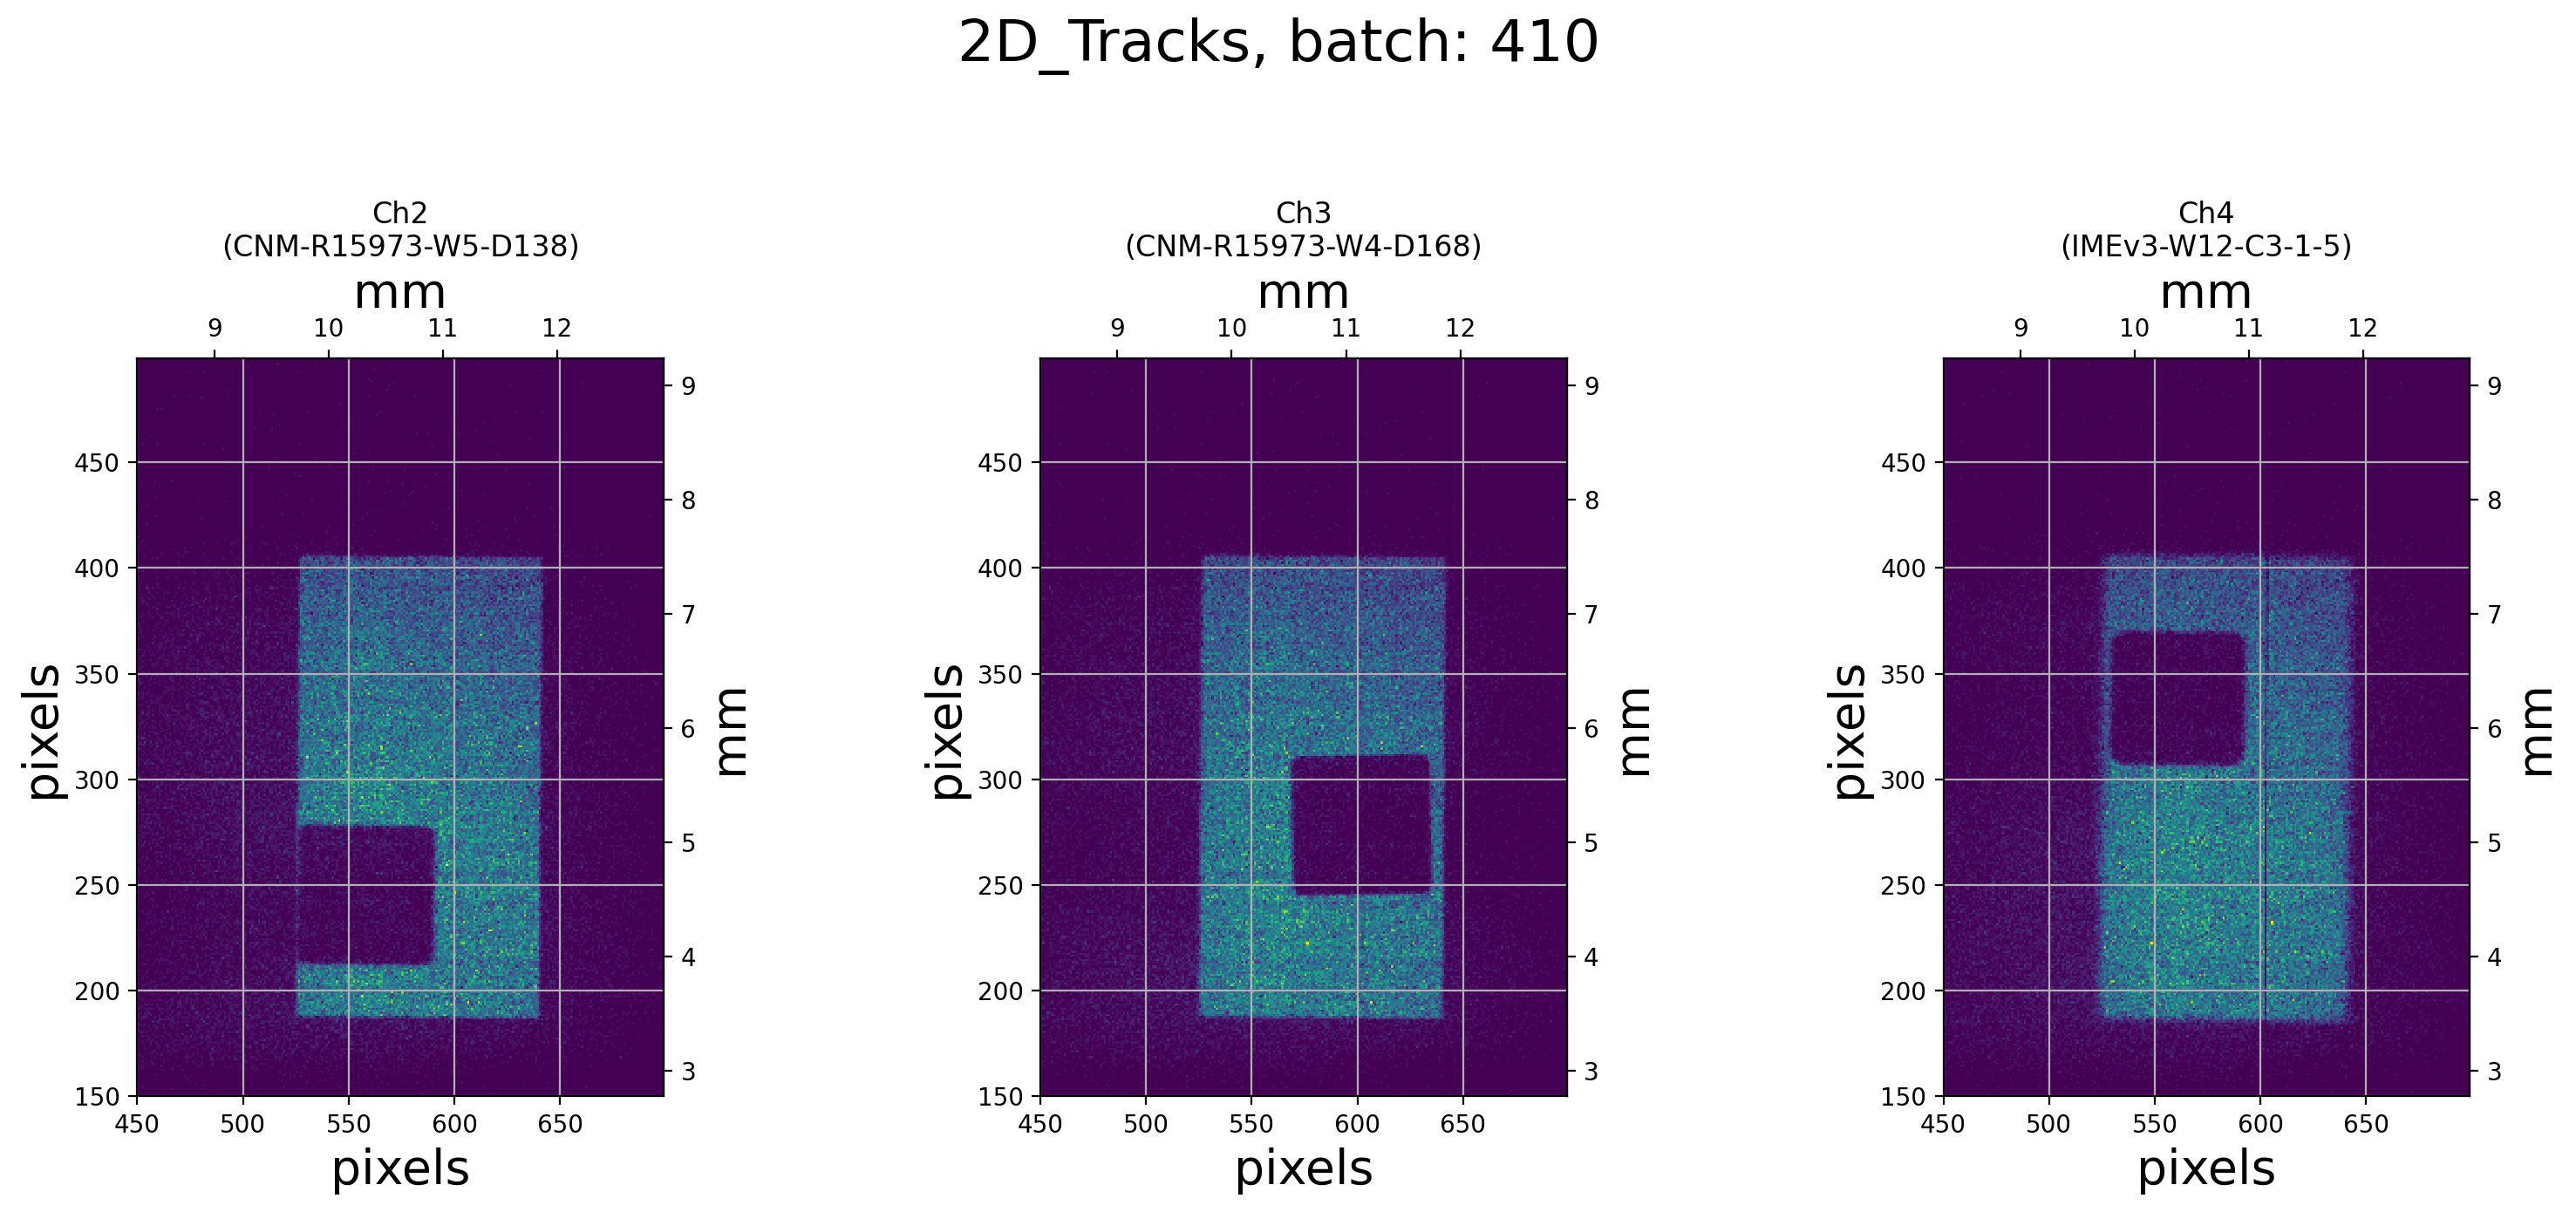

In [21]:
this_scope = "S2"
mask = [df[this_scope][f"pulseHeight_{i}"]<mins[this_scope][i] for i in range(1,4)]

fig,axes = plot(df[this_scope], "2D_Tracks", this_batch,bins=bins, mask=mask,
                sensors=sensors_list[this_batch][this_scope])

## Total efficiency with pulseHeight cut

In [33]:
# this_scope = "S1"
# dut = 1
# transimpedance = get_transimpedance(this_batch, this_scope) ### 4700 or  10700
# threshold_range = np.arange(0.5, 20, 0.5)

# ### full surface and pulseHeight cut
# efficiency_range = []
# error_range = []
# geometry = geometry_mask(df[this_scope], bins=bins, bins_find_min='rice', DUT_number=dut)
# pulseHeight = df[this_scope][f"pulseHeight_{dut}"]>mins[this_scope][dut]
# for charge in threshold_range:
#     ### efficiency with error
#     efficiency_range.append(efficiency_error(
#         df[this_scope][f"charge_{dut}"].loc[np.logical_and(geometry,pulseHeight)]/transimpedance[dut-1], charge)[0])
#     error_range.append(efficiency_error(
#         df[this_scope][f"charge_{dut}"].loc[np.logical_and(geometry,pulseHeight)]/transimpedance[dut-1], charge)[1]) 

# fig, ax = plt.subplots(figsize=(10,6), dpi=150)
# ax.errorbar(threshold_range, efficiency_range, yerr=error_range, marker='.', markersize=3, linewidth=0,
#             elinewidth=1, ecolor='k', capsize=1.5,
#         label=f"Ch{dut+1}, Total tracks: {df[this_scope][f'charge_{dut}'].loc[geometry].size}")

# ax.set_title(f"Total efficiency depending on threshold charge \n \
# on full surface of Ch{dut+1}: {sensors_list[this_batch][this_scope][f'Ch{dut+1}']}, batch {this_batch} \n \
# (with pulseHeight cut)")
# ax.set_xlabel("Threshold charge (fC)")
# ax.set_ylabel("Total efficiency")
# ax.axhline(0.95, label="95% efficiency", color='r', alpha=0.4, linewidth=2)
# ax.grid('--')
# ax.legend()
# # fig.savefig(f"..\various plots\Total_efficiency_change_{this_batch}_{this_scope}_DUT{dut}_pulseheight_cut.jpg")


## Efficiency in the central part 
Calculate the efficiency in the central $0.5x0.5$ $mm^2$

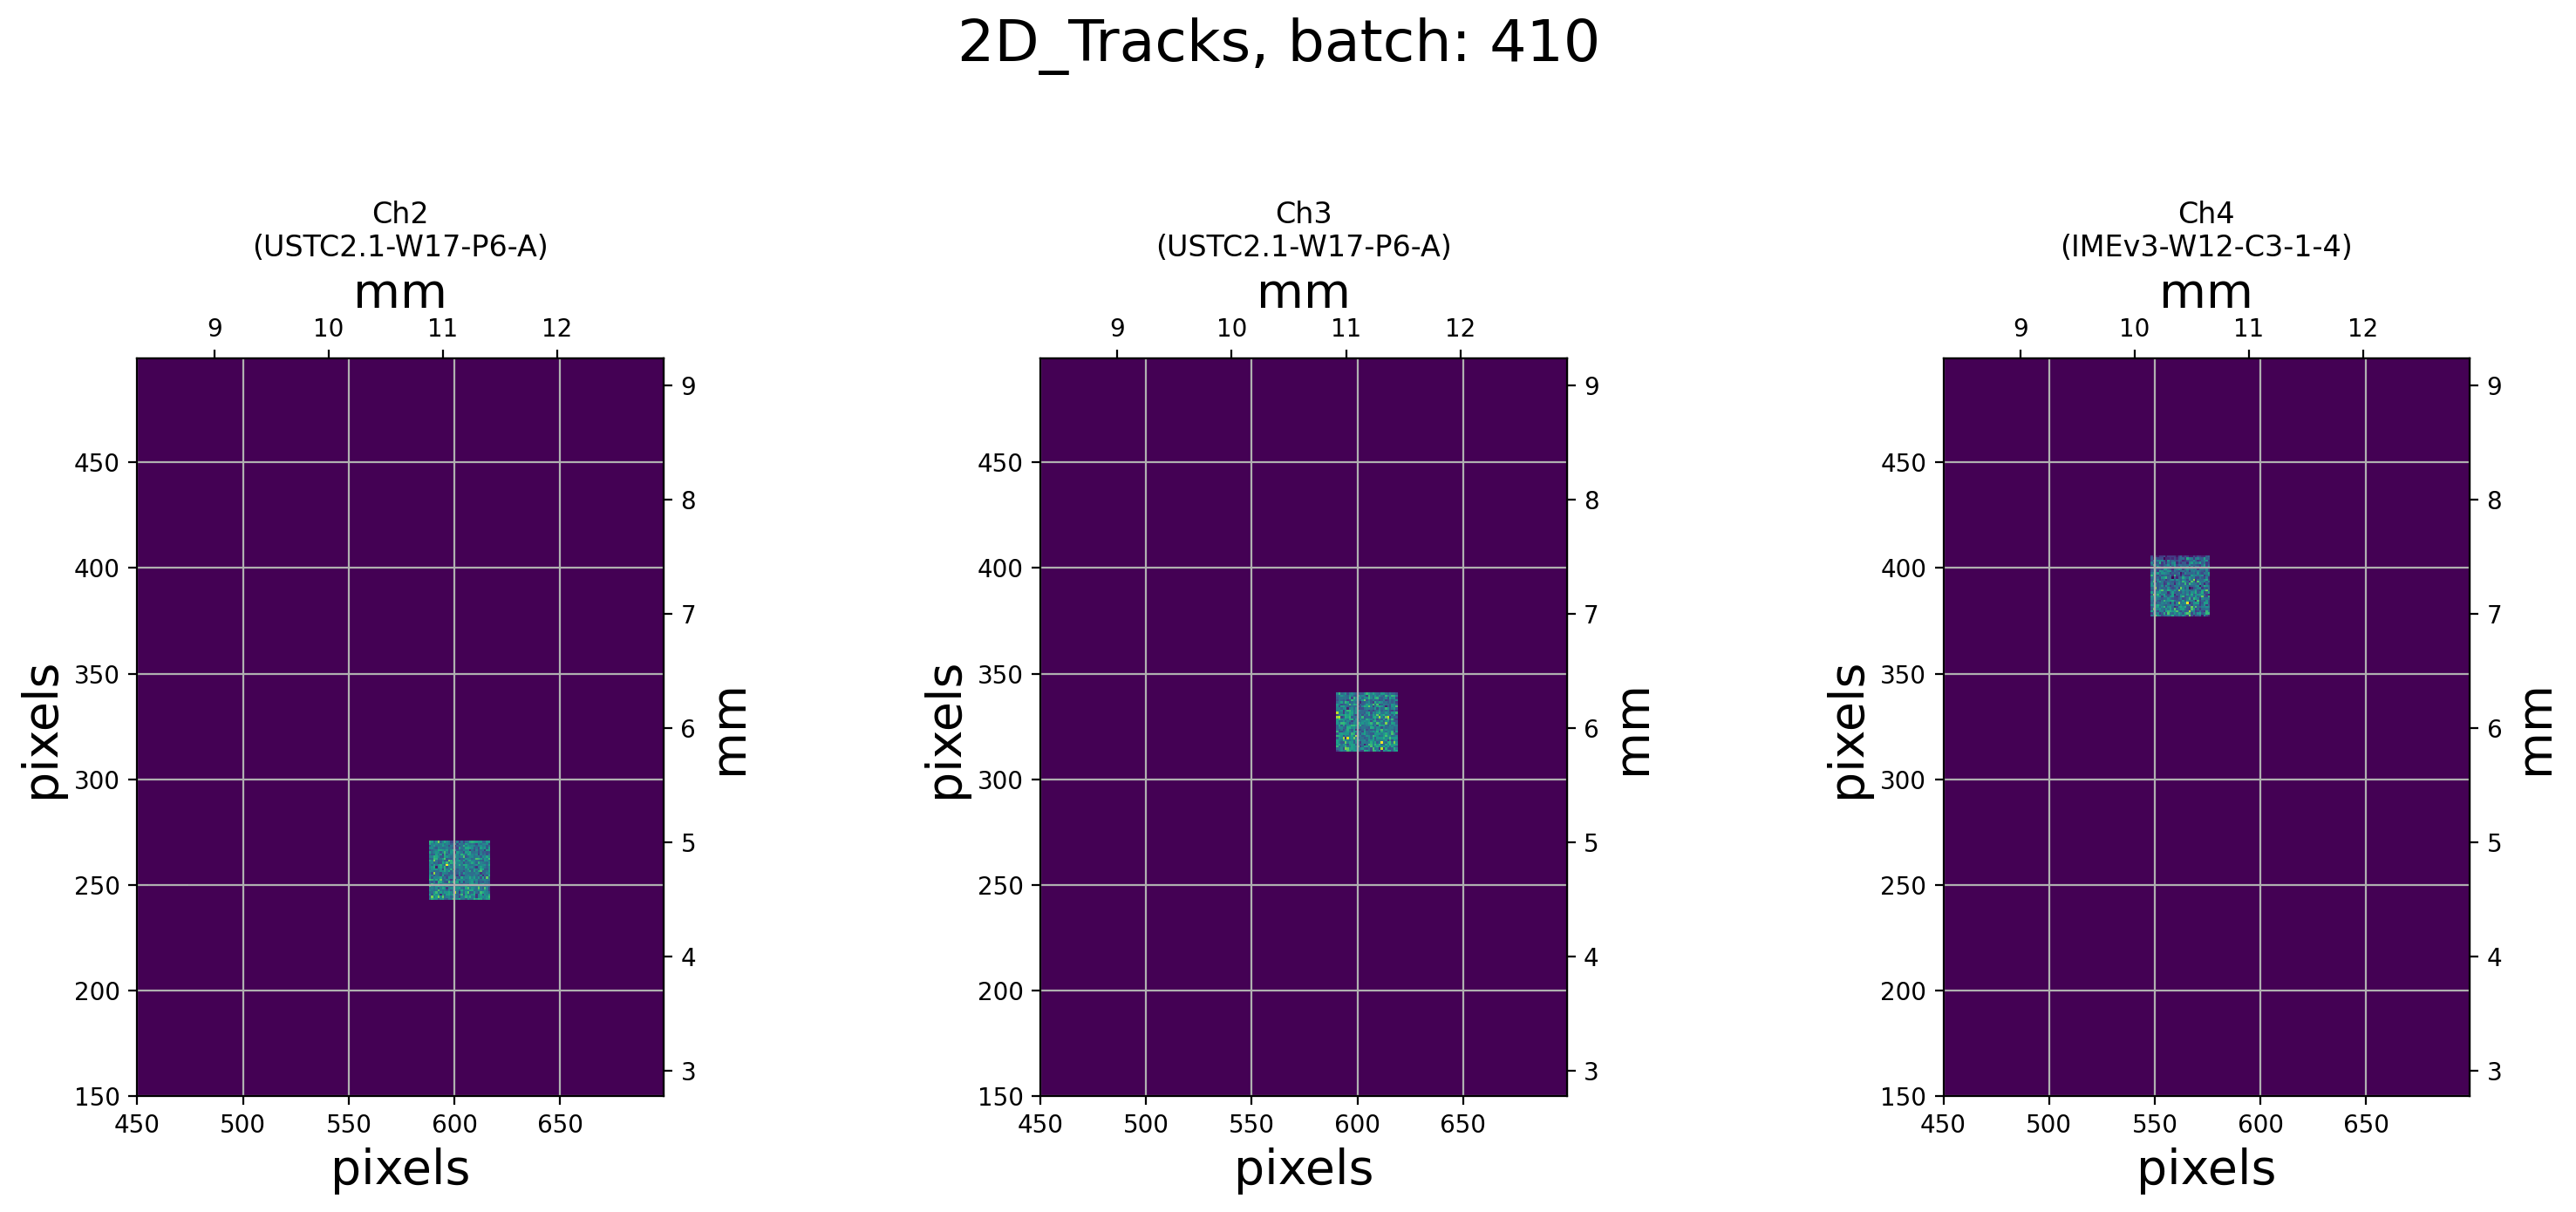

In [44]:
mask = [geometry_mask(df[this_scope], bins=bins, bins_find_min='rice', DUT_number=i, only_center=True) for i in range(1,4)]

fig,axes = plot(df[this_scope], "2D_Tracks", this_batch, bins=bins, mask=mask,
                sensors=sensors_list[this_batch][this_scope])

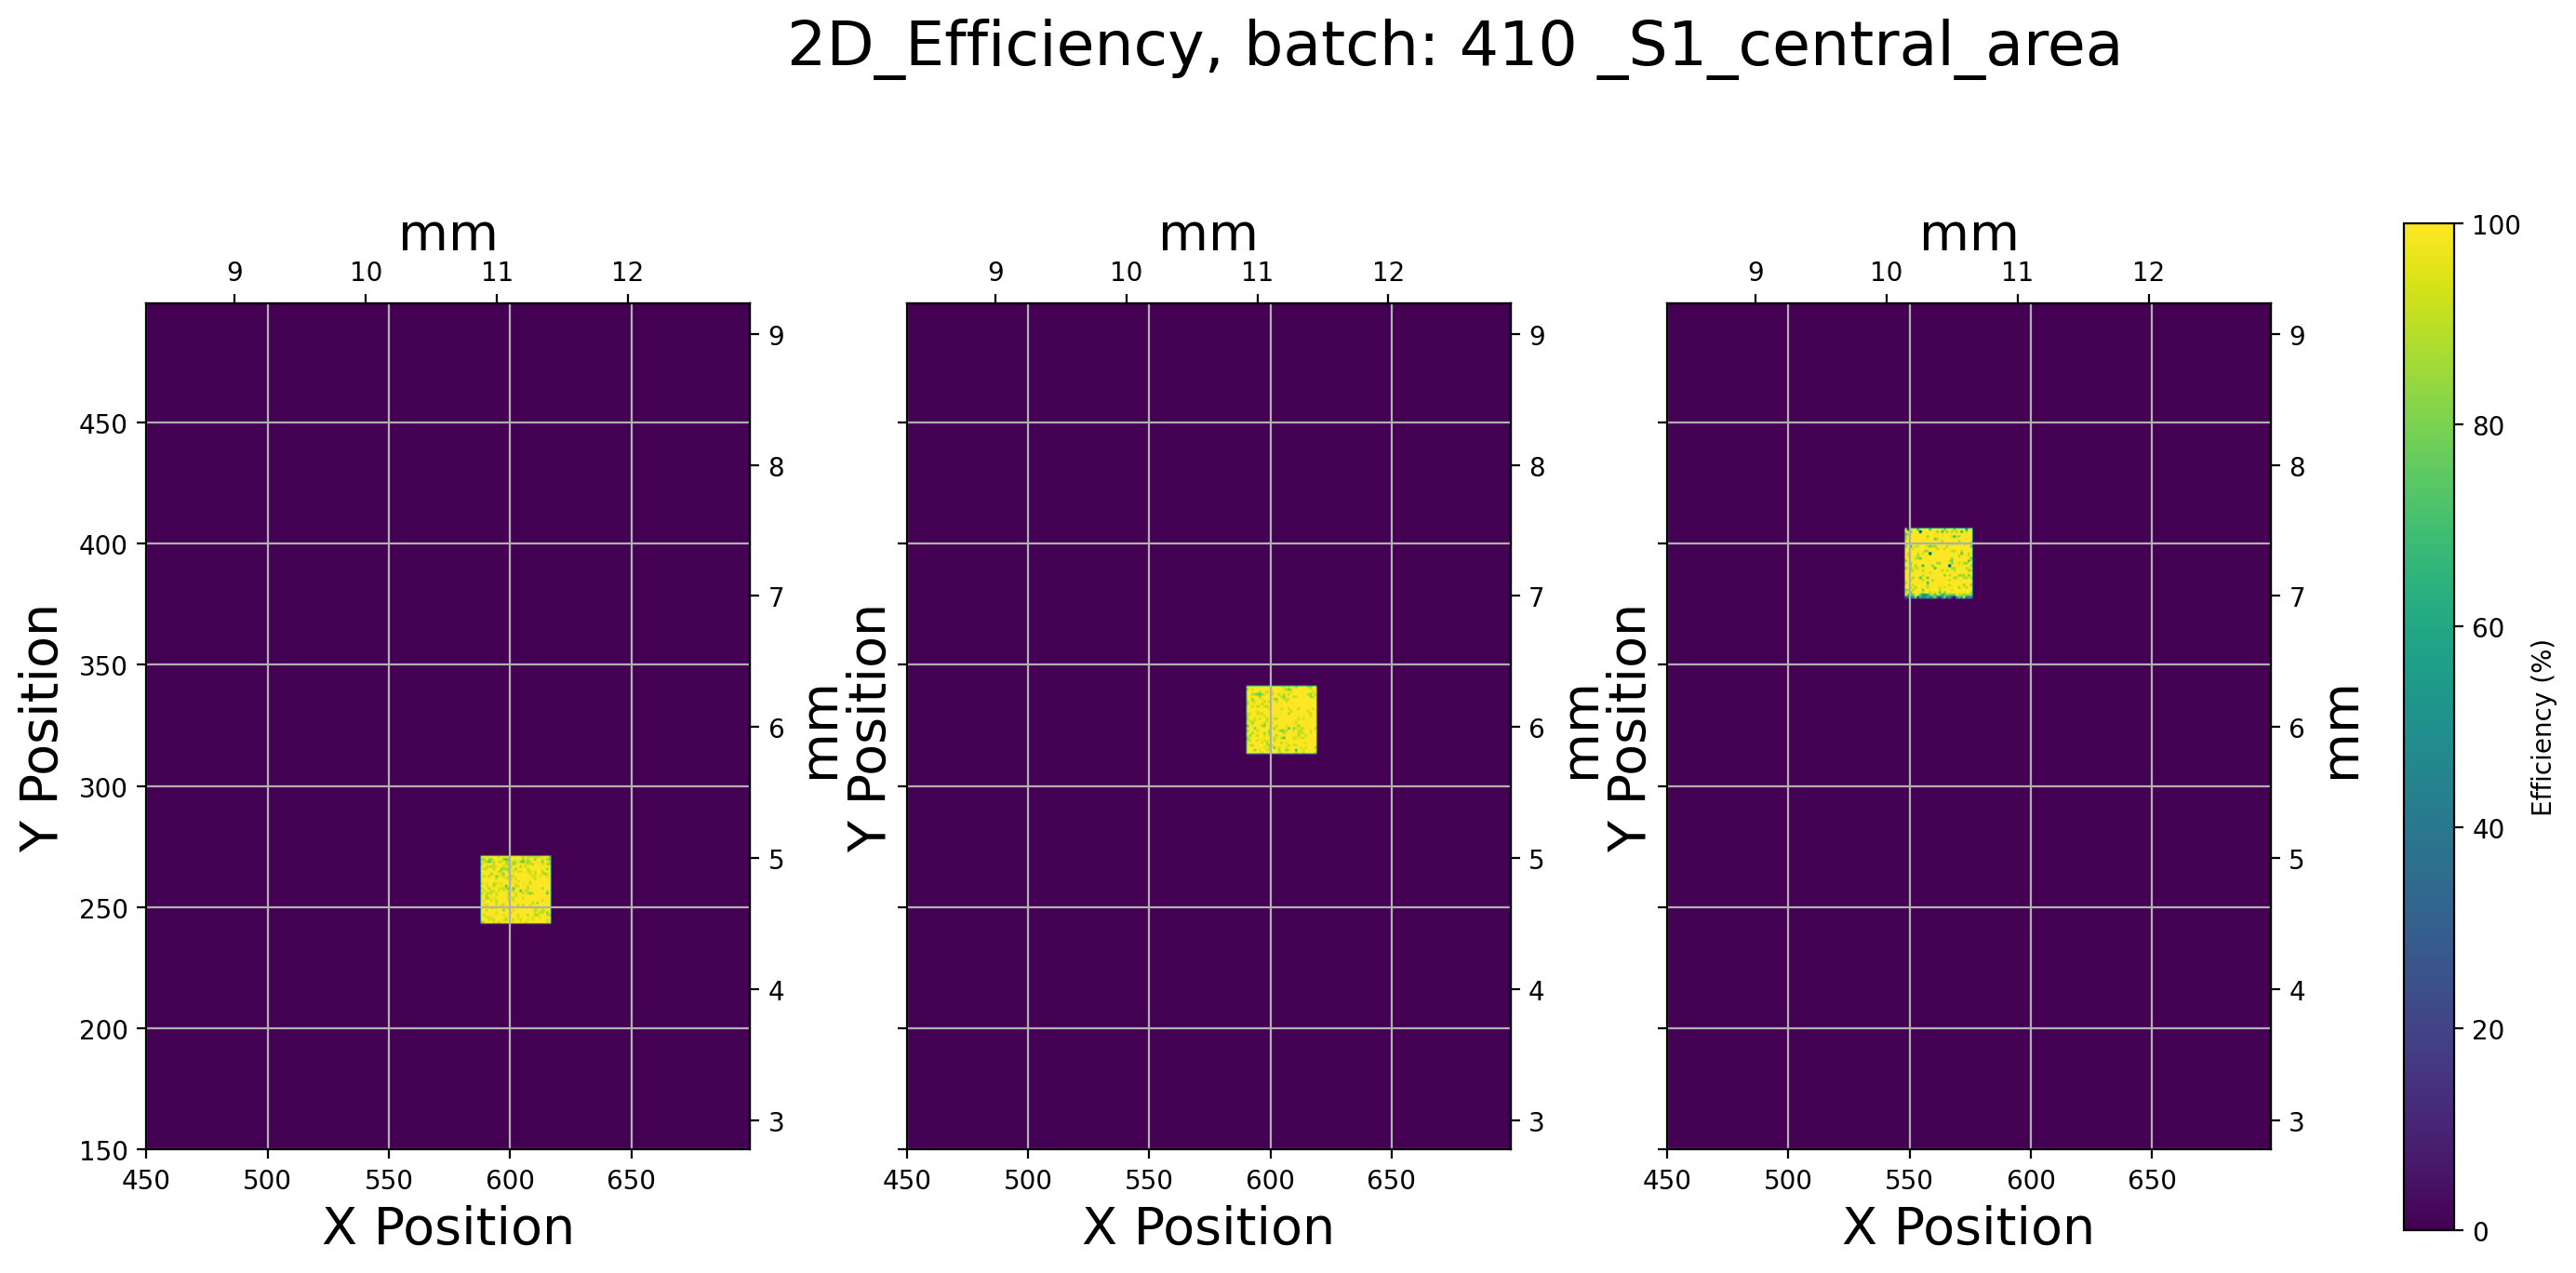

In [75]:
fig, axes = plot(df[this_scope],"2D_Efficiency", this_batch, bins=bins, sensors=sensors_list[this_batch][this_scope],
    transimpedance=get_transimpedance(this_batch,this_scope), threshold_charge=threshold_charge,
                no_geometry_cut=False, only_center=True, savefig=True, savefig_details=f"_{this_scope}_central_area")
fig

In [32]:
# ### Efficiency in the central part WITHOUT pulseHeight cut
# transimpedance = get_transimpedance(this_batch, this_scope) ### 4700 or  10700
# # dut = 3

# efficiency_range = []
# error_range = []
# threshold_range = np.arange(0.5, 20, 0.5)
# geometry = geometry_mask(df[this_scope], bins=bins, bins_find_min='rice', DUT_number=dut, only_center=True)
# # pulseHeight = df[this_scope][f"pulseHeight_{dut}"]>mins[this_scope][dut]
# for charge in threshold_range:
#     ### efficiency with error
#     efficiency_range.append(efficiency_error(
#         df[this_scope][f"charge_{dut}"].loc[geometry]/transimpedance[dut-1], charge)[0])
#     error_range.append(efficiency_error(
#         df[this_scope][f"charge_{dut}"].loc[geometry]/transimpedance[dut-1], charge)[1]) 

# fig, ax = plt.subplots(figsize=(10,6), dpi=150)
# ax.errorbar(threshold_range, efficiency_range, yerr=error_range, marker='.', markersize=3, linewidth=0,
#             elinewidth=1, ecolor='k',capsize=1.5,
#         label=f"Total tracks: {df[this_scope][f'charge_{dut}'].loc[geometry].size}")
# ax.set_title(f"Total efficiency depending on threshold charge \n \
# on central surface ($0.5x0.5mm^2$) of Ch{dut+1}: {sensors_list[this_batch][this_scope][f'Ch{dut+1}']}, batch {this_batch} \n \
# (no other cut)")
# ax.set_xlabel("Threshold charge (fC)")
# ax.set_ylabel("Total efficiency")
# ax.axhline(0.95, label="95% efficiency", color='r', alpha=0.4, linewidth=2)
# ax.grid('--')
# ax.legend()
# # fig.savefig(f"../various plots/Total_efficiency_change_central_area_{this_batch}_{this_scope}_DUT{dut}_no_cut.jpg")

## Comparing $\Delta$t with pulseHeight

In [34]:
mins

{'S1': [None, 41.479523, 40.815742, 35.258324],
 'S2': [None, 50.26712, 49.795753, 29.14871]}

In [52]:
# this_scope = "S2"
# dut = 2
# fig, ax = plt.subplots(figsize=(10,8), dpi=300)
# ax.plot(np.array(df[this_scope]["timeCFD50_0"]-df[this_scope][f"timeCFD50_{dut}"]),np.array(df[this_scope][f"pulseHeight_{dut}"]),'x', markersize=.5)
# ax.axhline(mins[this_scope][dut],color='r',label="pulseHeight_cut, min: %.2f"%mins[this_scope][dut])
# ax.legend()
# ax.grid('--')

In [53]:
# this_scope = "S2"
# dut = 2
# fig, ax = plt.subplots(figsize=(10,8), dpi=300)
# ax.plot(np.array(df[this_scope]["timeCFD50_0"]-df[this_scope][f"timeCFD50_{dut}"]),np.array(df[this_scope][f"charge_{dut}"])/transimpedance[dut-1],'x', markersize=.5)
# ax.grid('--')

In [54]:
# this_scope = "S1"
# fig, ax = plt.subplots(figsize=(10,8), dpi=300)

# for dut in range(1,4):
# # dut = 1
#     ax.plot(np.array(df[this_scope][f"pulseHeight_{dut}"]),np.array(df[this_scope][f"charge_{dut}"])/transimpedance[dut-1],'x', markersize=.5)
#     ax.grid('--')

In [ ]:
# # _,hist_bins,_,fig,ax = plot_histogram(df[this_scope]["charge_1"].iloc[np.where(time_cut)])
# _,_,_,fig,ax = plot_histogram(df[this_scope]["charge_1"].iloc[np.where(pulse_cut)],bins=hist_bins)#, fig_ax=(fig,ax))
# ax.semilogy() 
# fig

## Ratio plots

Text(0.5, 1.15, 'Time difference with ratio plot when pulseHeight cut is applied \n Batch: 410, Oscilloscope: S1')

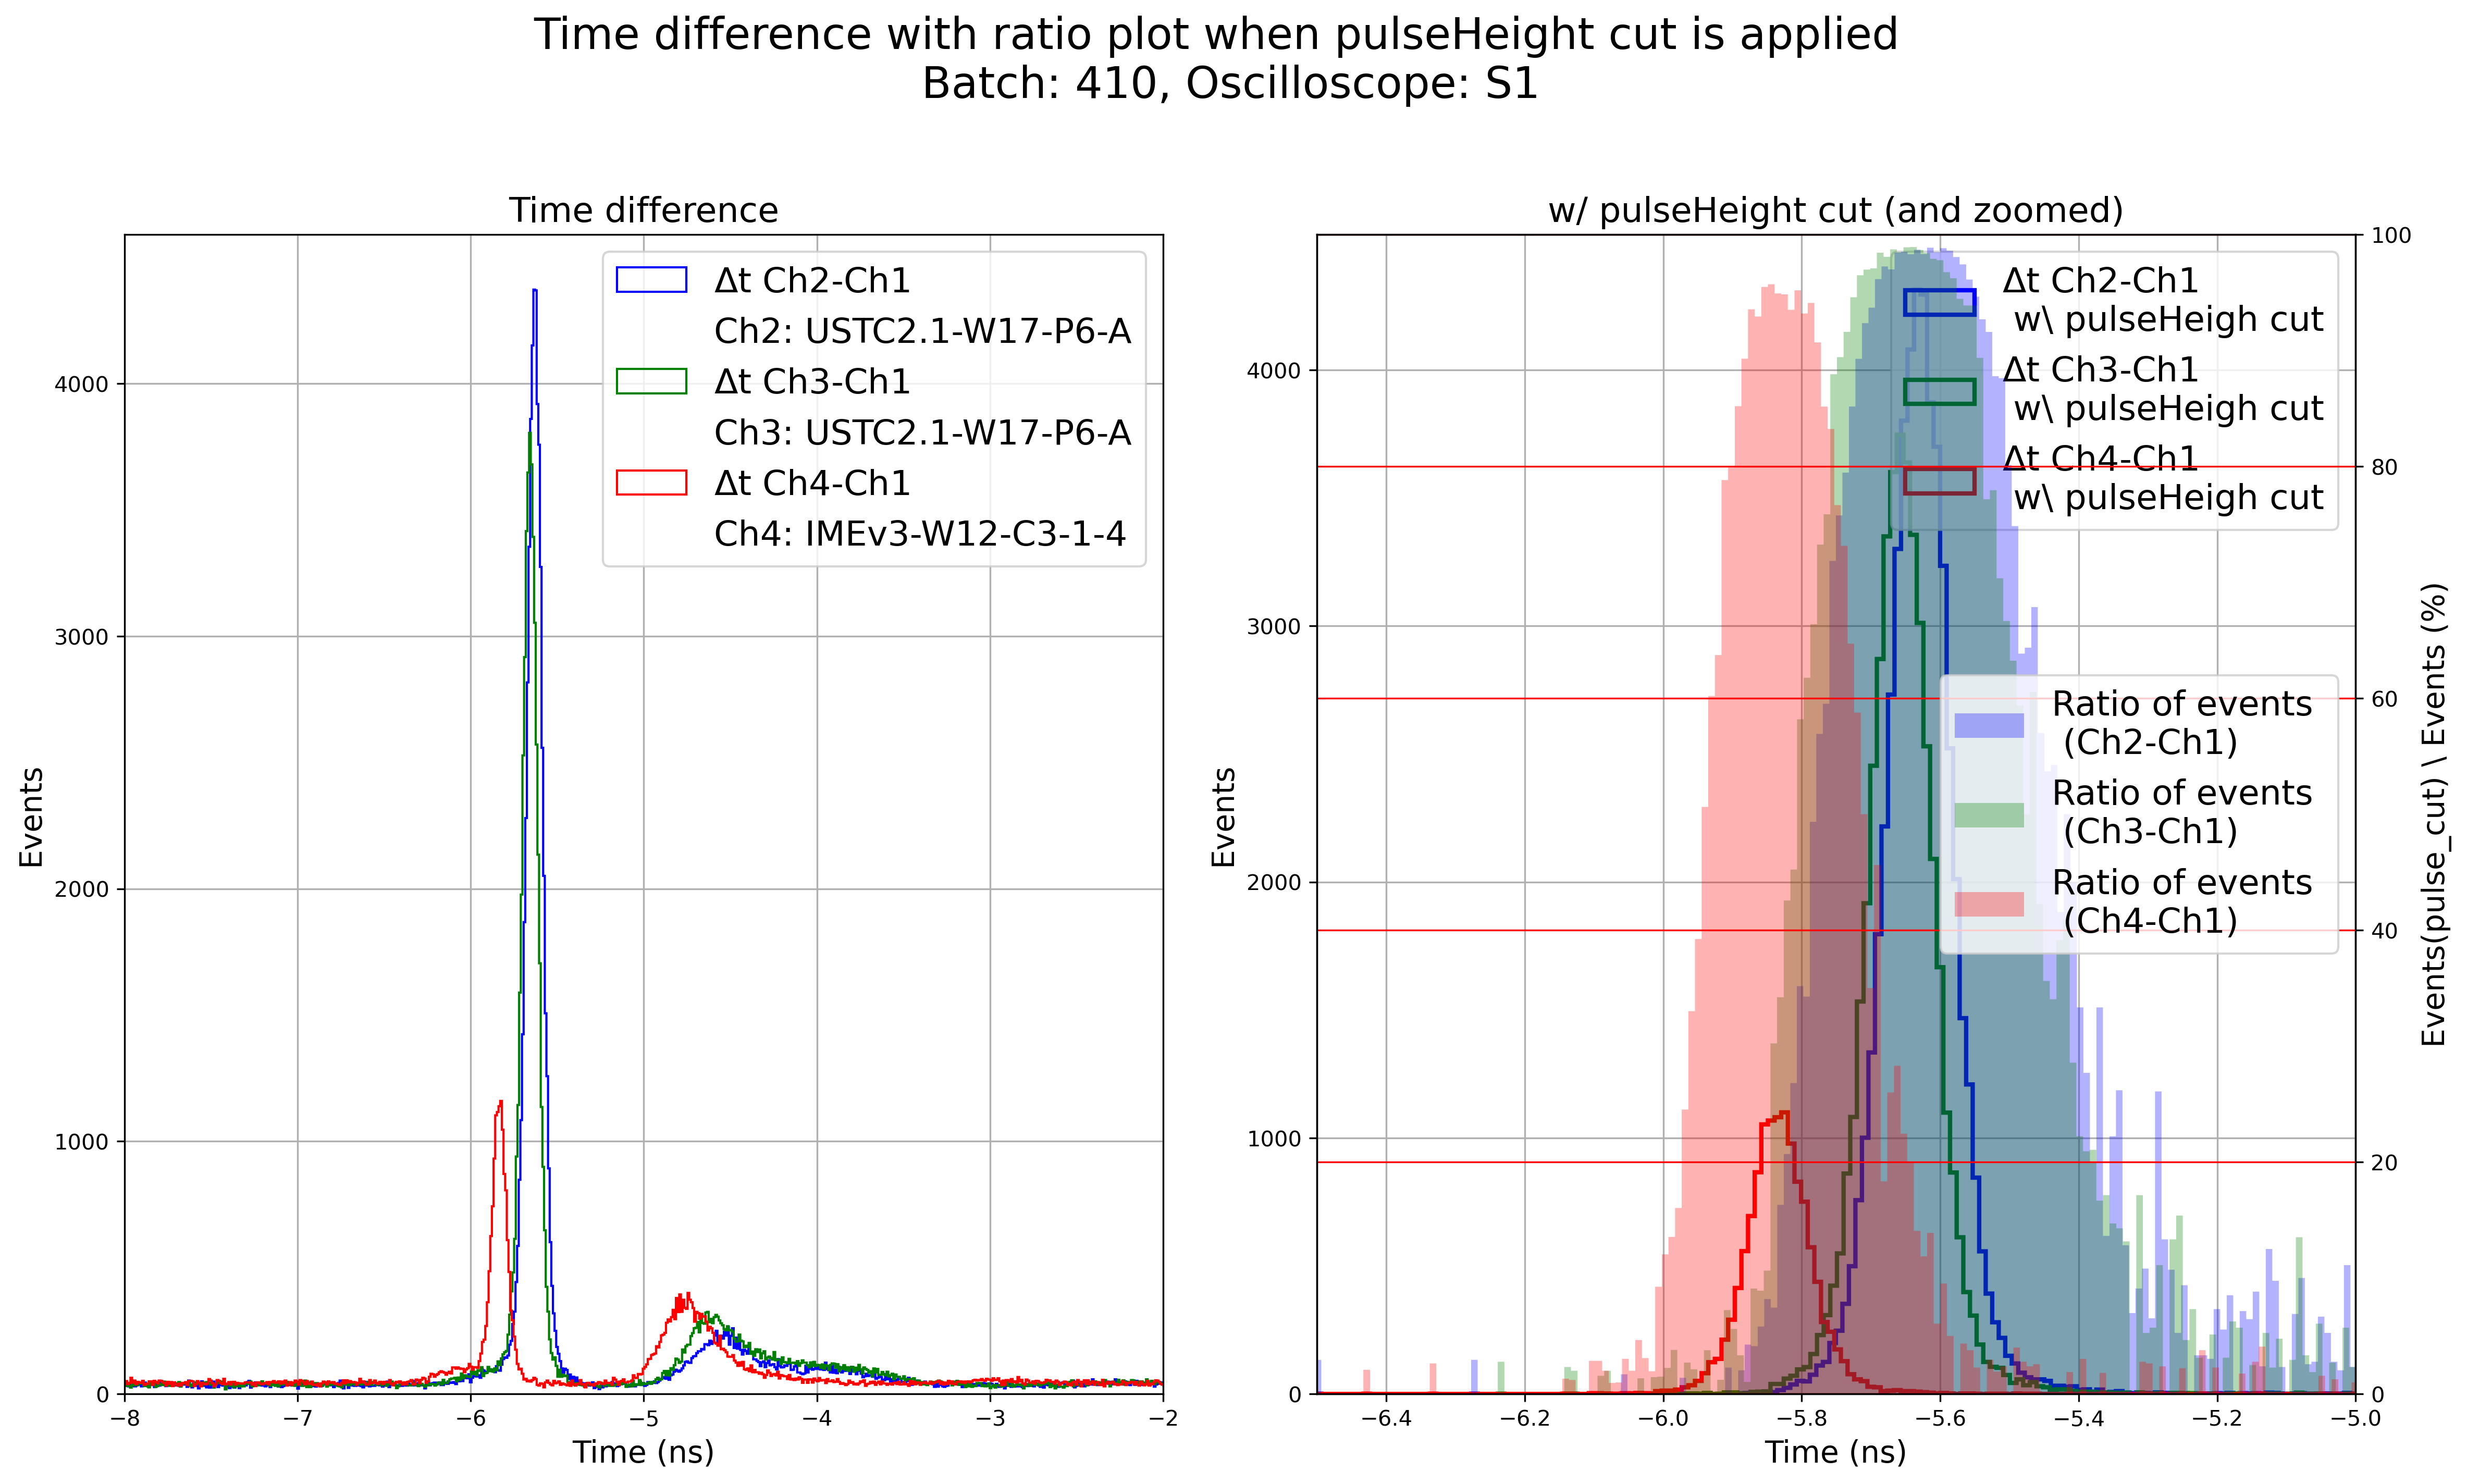

In [20]:
### THIS IS PLOTTING THE RATIO OF DATA THAT IS LEFT WHEN APPLYIN A PULSEHEIGHT CUT
this_scope = "S1"

colormap = ['k','b','g','r']

fig, axes = plt.subplots(figsize=(15,8),nrows=1,ncols=2, dpi=300)
fig.tight_layout(w_pad=4, h_pad=4)
ax2 = axes[1].twinx() 
ax2.grid('-', axis='y', color='r')

for dut in range(1,4):
    pulse_cut = df[this_scope][f"pulseHeight_{dut}"]>mins[this_scope][dut]
    hist, my_bins,_,_,_ = plot_histogram((df[this_scope][f"timeCFD50_{dut}"]-df[this_scope]["timeCFD50_0"])/1000, bins=10000, label=f"$\Delta$t Ch{dut+1}-Ch1",fig_ax=(fig,axes[0]), color=colormap[dut]) ### MCP - CERN1
    axes[0].plot([],[],' ',label=f"Ch{dut+1}: {sensors_list[this_batch][this_scope][f'Ch{dut+1}']}")
    hist_pulse_cut,_,_,_,_ = plot_histogram((df[this_scope][f"timeCFD50_{dut}"].loc[pulse_cut]-df[this_scope]["timeCFD50_0"].loc[pulse_cut])/1000, bins=my_bins, label=f"$\Delta$t Ch{dut+1}-Ch1 \n w\ pulseHeigh cut", fig_ax=(fig,axes[1]), linewidth=2, color=colormap[dut])  ### MCP - CERN3
#     time_peak,_ = find_peaks(hist_pulse_cut, prominence=np.max(hist_pulse_cut)/10)
    ratio = np.divide(hist_pulse_cut, hist, where = hist!=0)
#     axes[0].stairs(ratio*100, my_bins, alpha=0.5, label='Filtered Ratio', color=colormap[dut])
    ax2.stairs(ratio*100, my_bins, alpha=0.3, label=f"Ratio of events \n (Ch{dut+1}-Ch1)", color=colormap[dut], fill=True)


axes[0].set_title(f"Time difference", fontsize=16)
axes[0].set_xlabel("Time (ns)", fontsize=14)
axes[0].set_ylabel("Events", fontsize=14)
axes[0].set_xlim(-8,-2)

axes[1].set_title("w/ pulseHeight cut (and zoomed)", fontsize=16)
axes[1].set_xlabel("Time (ns)", fontsize=14)
axes[1].set_ylabel("Events", fontsize=14)
axes[1].set_xlim(-6.5,-5)

ax2.set_ylabel("Events(pulse_cut) \ Events (%)", fontsize=14)
ax2.set_ylim(0,100)
ax2.tick_params

axes[0].legend(fontsize=16)
axes[1].legend(fontsize=16)
ax2.legend(fontsize=16, loc='right')
fig.suptitle(f"Time difference with ratio plot when pulseHeight cut is applied \
\n Batch: {this_batch}, Oscilloscope: {this_scope}",y=1.15, fontsize=20)
# fig.savefig(f"../various plots/time_difference{this_batch}_{this_scope}_all_DUTs_with_ratio_plot.jpg",bbox_inches='tight')

### New ratio plot

Text(0.5, 1, 'Time difference with ratio plot when pulseHeight cut is applied \n Batch: 410, Oscilloscope: S1')

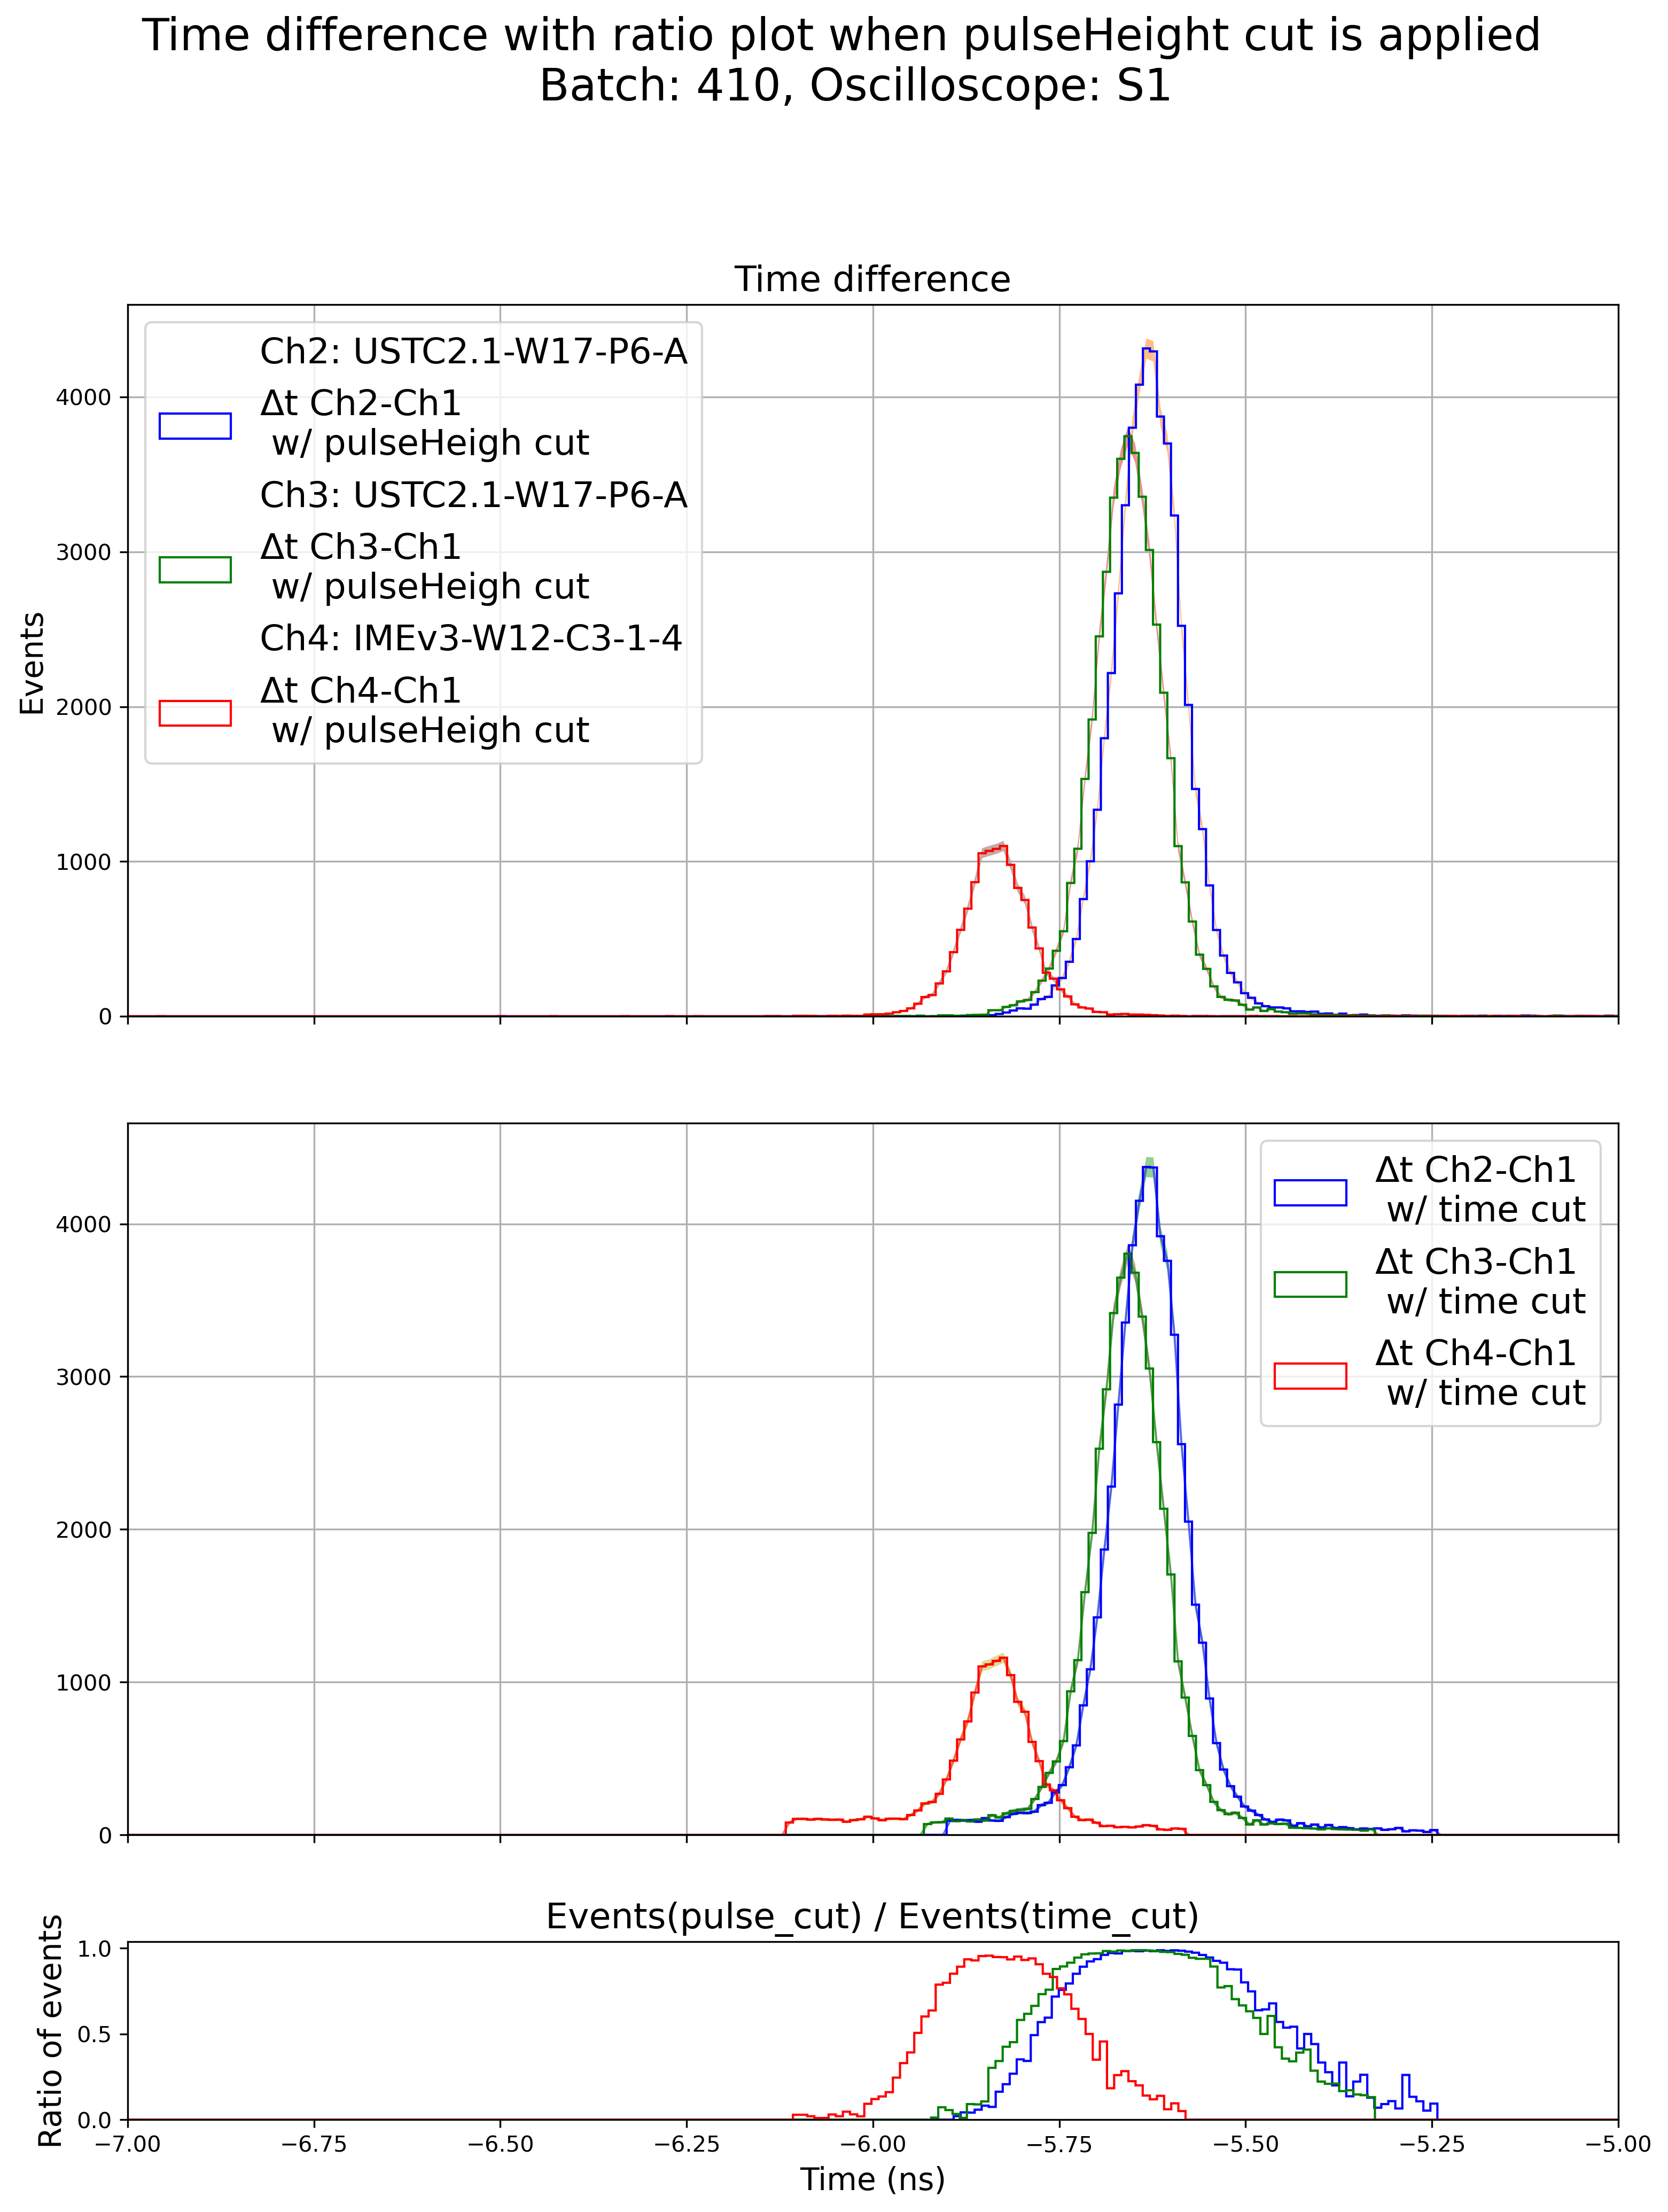

In [23]:
### THIS IS PLOTTING THE RATIO OF DATA THAT IS LEFT WHEN APPLYIN A PULSEHEIGHT CUT
this_scope = "S1"

colormap = ['k','b','g','r']
spec = {'height_ratios':[4,4,1], 'hspace':0.2}   # gridspec keywords arguments
fig, axes = plt.subplots(figsize=(12,15),nrows=3, ncols=1, gridspec_kw=spec, sharex=True, dpi=300)

all_time_cut = [None]

for dut in range(1,4):
    pulse_cut = df[this_scope][f"pulseHeight_{dut}"]>mins[this_scope][dut]
    hist, my_bins,_,_,_ = plot_histogram((df[this_scope][f"timeCFD50_{dut}"]-df[this_scope]["timeCFD50_0"])/1000,
                                         bins=10000, fig_ax=(fig,axes[1]), color=colormap[dut], linewidth=0) #,label=f"$\Delta$t Ch{dut+1}-Ch1",) ### MCP - CERN1
    
    axes[0].plot([],[],' ',label=f"Ch{dut+1}: {sensors_list[this_batch][this_scope][f'Ch{dut+1}']}")
    
    hist_pulse_cut,_,_,_,_ = plot_histogram((df[this_scope][f"timeCFD50_{dut}"].loc[pulse_cut]-df[this_scope]["timeCFD50_0"].loc[pulse_cut])/1000,
                                            poisson_err=True, error_band=True, bins=my_bins, color=colormap[dut],
                                            fig_ax=(fig,axes[0]), label=f"$\Delta$t Ch{dut+1}-Ch1 \n w/ pulseHeigh cut")  ### MCP - CERN3

    peaks, info_peaks = find_peaks(hist_pulse_cut, prominence=np.max(hist_pulse_cut)/10)
    left_cut = (df[this_scope][f"timeCFD50_{dut}"]-df[this_scope]["timeCFD50_0"])/1000>my_bins[info_peaks['left_bases'][0]]
    right_cut = (df[this_scope][f"timeCFD50_{dut}"]-df[this_scope]["timeCFD50_0"])/1000<my_bins[info_peaks['right_bases'][0]]
    all_time_cut.insert(dut, np.logical_and(left_cut, right_cut))
    time_cut = np.logical_and(left_cut, right_cut)
    hist_time_cut,_,_,_,_ = plot_histogram((df[this_scope][f"timeCFD50_{dut}"].loc[time_cut]-df[this_scope]["timeCFD50_0"].loc[time_cut])/1000,
                                           poisson_err=True, error_band=True, bins=my_bins, linewidth=1, color=colormap[dut],
                                           fig_ax=(fig,axes[1]), label=f"$\Delta$t Ch{dut+1}-Ch1 \n w/ time cut")  ### MCP - CERN3
    ratio = np.divide(hist_pulse_cut, hist_time_cut, where = hist_time_cut!=0)
    axes[2].stairs(ratio, my_bins, label=f"Ratio of events \n (Ch{dut+1}-Ch1)", color=colormap[dut])#, fill=True)

    
axes[0].set_title(f"Time difference", fontsize=16)
axes[0].set_ylabel("Events", fontsize=14)
axes[0].set_xlim(-7,-5)

axes[2].set_ylabel("Ratio of events", fontsize=14)
axes[2].set_xlabel("Time (ns)", fontsize=14)


axes[2].set_title("Events(pulse_cut) / Events(time_cut)", fontsize=16)

axes[0].legend(fontsize=16)
axes[1].legend(fontsize=16)

fig.suptitle(f"Time difference with ratio plot when pulseHeight cut is applied \
\n Batch: {this_batch}, Oscilloscope: {this_scope}",y=1, fontsize=20)
# fig.savefig(f"../various plots/time_difference_pulseheight_cut_time_cut_{this_batch}_{this_scope}_all_DUTs_with_ratio_plot.jpg",bbox_inches='tight')

<AxesSubplot:>

### Efficiency with time_cut

In [31]:
# this_scope = "S1"
# transimpedance = get_transimpedance(this_batch, this_scope) ### 4700 or  10700
# dut = 2

# efficiency_range = []
# error_range = []
# threshold_range = np.arange(0.5, 20, 0.5)
# geometry = geometry_mask(df[this_scope], bins=bins, bins_find_min='rice', DUT_number=dut)
# # pulseHeight = df[this_scope][f"pulseHeight_{dut}"]>mins[this_scope][dut]

# for charge in threshold_range:
#     ### efficiency with error
#     efficiency_range.append(efficiency_error(
#         df[this_scope][f"charge_{dut}"].loc[np.logical_and(geometry,all_time_cut[dut])]/transimpedance[dut-1], charge)[0])
#     error_range.append(efficiency_error(
#         df[this_scope][f"charge_{dut}"].loc[np.logical_and(geometry,all_time_cut[dut])]/transimpedance[dut-1], charge)[1]) 

# fig, ax = plt.subplots(figsize=(10,6), dpi=150)
# ax.errorbar(threshold_range, efficiency_range, yerr=error_range, marker='.', markersize=3, linewidth=0,
#             elinewidth=1, ecolor='k', capsize=1.5,
#         label=f"Total tracks: {df[this_scope][f'charge_{dut}'].loc[geometry].size}")
# ax.set_title(f"Total efficiency depending on threshold charge \n \
# on full surface of {sensors_list[this_batch][this_scope][f'Ch{dut+1}']}, batch {this_batch} \n \
# (with time cut)")
# ax.set_xlabel("Threshold charge (fC)")
# ax.set_ylabel("Total efficiency")
# ax.axhline(0.95, label="95% efficiency", color='r', alpha=0.4, linewidth=2)
# ax.grid('--')
# ax.legend()

# fig.savefig(f"../various plots/Total_efficiency_change_{this_batch}_{this_scope}_DUT{dut}_with_time_cut.jpg" ,bbox_inches='tight')

## Now combine all efficiencies

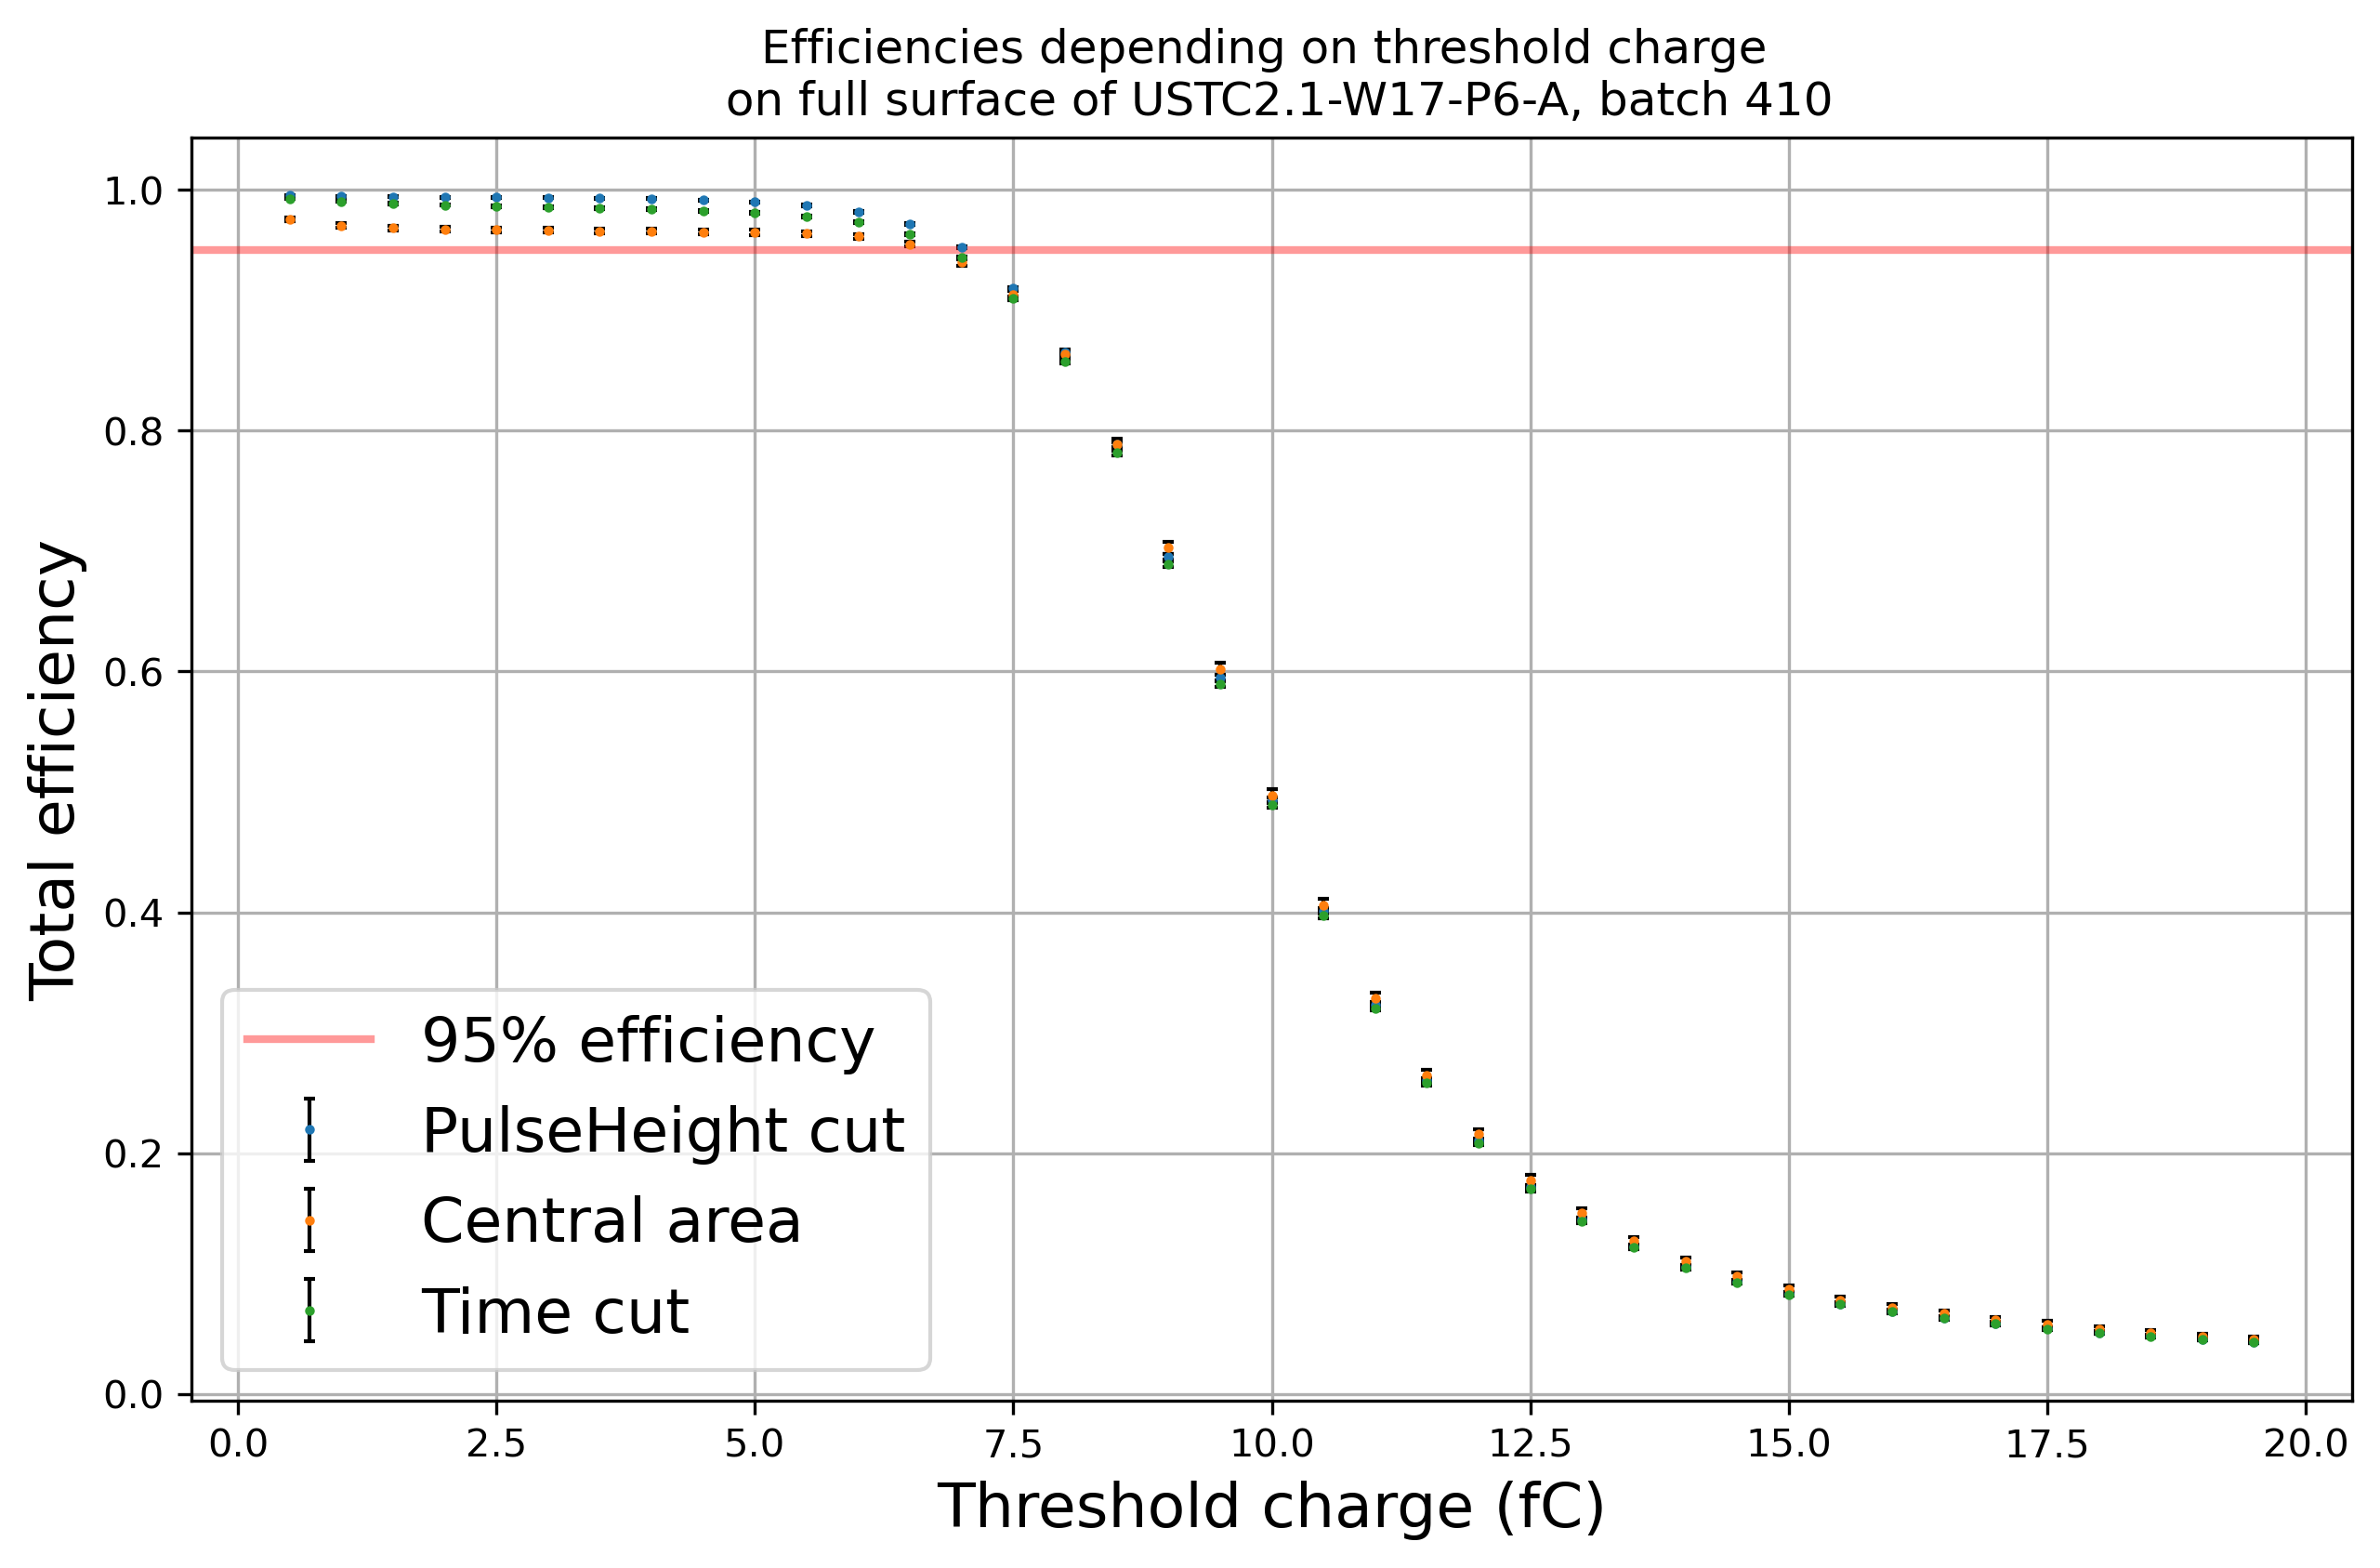

In [35]:
this_scope = "S1"
transimpedance = get_transimpedance(this_batch, this_scope) ### 4700 or  10700
dut = 1
threshold_range = np.arange(0.5, 20, 0.5)

efficiency_pulse_cut = []
error_pulse_cut = []

efficiency_center = []
error_center = []

efficiency_time_cut = []
error_time_cut = []

geometry = geometry_mask(df[this_scope], bins=bins, bins_find_min='rice', DUT_number=dut)
geometry_center = geometry_mask(df[this_scope], bins=bins, bins_find_min='rice', DUT_number=dut, only_center=True)
pulseHeight = df[this_scope][f"pulseHeight_{dut}"]>mins[this_scope][dut]

for charge in threshold_range:
    ### efficiency with pulseHeight cut
    efficiency_pulse_cut.append(efficiency_error(
        df[this_scope][f"charge_{dut}"].loc[np.logical_and(geometry,pulseHeight)]/transimpedance[dut-1], charge)[0])
    error_pulse_cut.append(efficiency_error(
        df[this_scope][f"charge_{dut}"].loc[np.logical_and(geometry,pulseHeight)]/transimpedance[dut-1], charge)[1]) 
    ### efficiency central area
    efficiency_center.append(efficiency_error(
        df[this_scope][f"charge_{dut}"].loc[geometry_center]/transimpedance[dut-1], charge)[0])
    error_center.append(efficiency_error(
        df[this_scope][f"charge_{dut}"].loc[geometry_center]/transimpedance[dut-1], charge)[1]) 
    ### efficiency with time cut
    efficiency_time_cut.append(efficiency_error(
        df[this_scope][f"charge_{dut}"].loc[np.logical_and(geometry,all_time_cut[dut])]/transimpedance[dut-1], charge)[0])
    error_time_cut.append(efficiency_error(
        df[this_scope][f"charge_{dut}"].loc[np.logical_and(geometry,all_time_cut[dut])]/transimpedance[dut-1], charge)[1]) 

fig, ax = plt.subplots(figsize=(10,6), dpi=300)
### pulseHeight cut
ax.errorbar(threshold_range, efficiency_pulse_cut, yerr=error_pulse_cut, marker='.', markersize=3, linewidth=0,
            elinewidth=1, ecolor='k', capsize=1.5,
            label=f"PulseHeight cut")#, #tracks: {df[this_scope][f'charge_{dut}'].loc[geometry].size}")
### central area
ax.errorbar(threshold_range, efficiency_center, yerr=error_center, marker='.', markersize=3, linewidth=0,
            elinewidth=1, ecolor='k', capsize=1.5,
            label=f"Central area")#, #tracks: {df[this_scope][f'charge_{dut}'].loc[geometry].size}")
### time cut
ax.errorbar(threshold_range, efficiency_time_cut, yerr=error_time_cut, marker='.', markersize=3, linewidth=0,
            elinewidth=1, ecolor='k', capsize=1.5,
            label=f"Time cut")#, #tracks: {df[this_scope][f'charge_{dut}'].loc[geometry].size}")

ax.set_title(f"Efficiencies depending on threshold charge \n \
on full surface of {sensors_list[this_batch][this_scope][f'Ch{dut+1}']}, batch {this_batch}")
ax.set_xlabel("Threshold charge (fC)",fontsize=16)
ax.set_ylabel("Total efficiency",fontsize=16)
ax.axhline(0.95, label="95% efficiency", color='r', alpha=0.4, linewidth=2)
ax.grid('--')
ax.legend(fontsize=16)
# fig.savefig(f"../various plots/Total_efficiencies_change_{this_batch}_{this_scope}_DUT{dut}_different_cuts.jpg")

peak position: -5.8295703 ns
peak position: -5.6407466 ns


Text(0.5, 1.1, 'Batch: 410, Oscilloscope: S2')

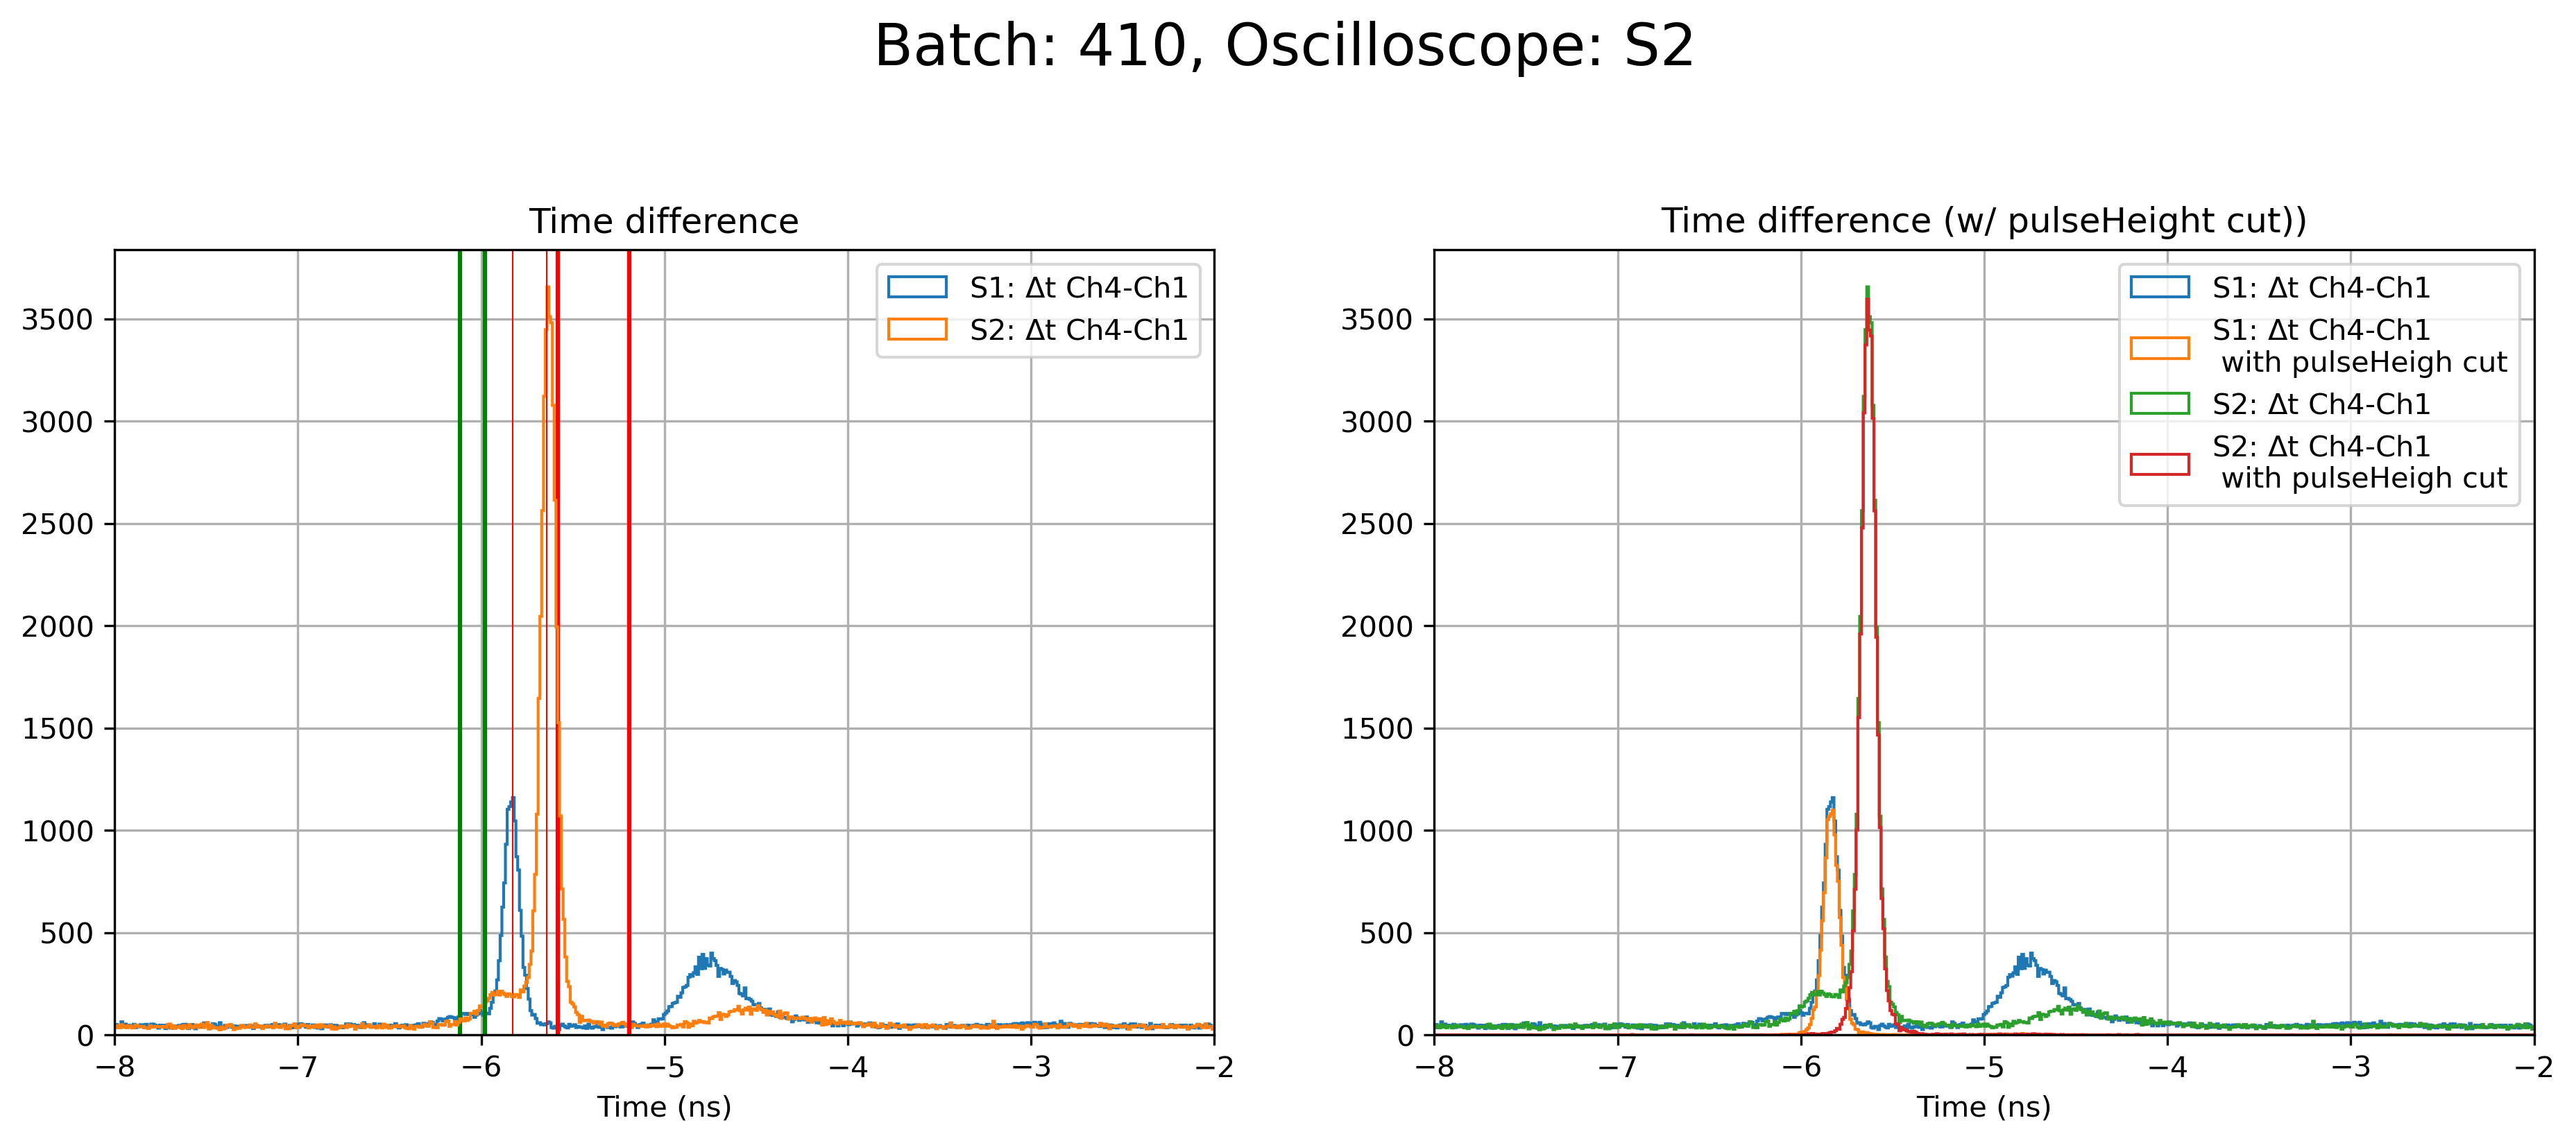

In [52]:
dut = 3

fig, axes = plt.subplots(figsize=(15,5),nrows=1,ncols=2, dpi=300)
for this_scope in ["S1","S2"]:
    pulse_cut = df[this_scope][f"pulseHeight_{dut}"]>mins[this_scope][dut]
    hist,my_bins,_,_,_ = plot_histogram((df[this_scope][f"timeCFD50_{dut}"]-df[this_scope]["timeCFD50_0"])/1000, bins=10000, label=f"{this_scope}: $\Delta$t Ch{dut+1}-Ch1",fig_ax=(fig,axes[0])) ### MCP - CERN1
    plot_histogram((df[this_scope][f"timeCFD50_{dut}"]-df[this_scope]["timeCFD50_0"])/1000, bins=my_bins, label=f"{this_scope}: $\Delta$t Ch{dut+1}-Ch1",fig_ax=(fig,axes[1]));### MCP - CERN1
    hist_pulse_cut,_,_,_,_ = plot_histogram((df[this_scope][f"timeCFD50_{dut}"].loc[pulse_cut]-df[this_scope]["timeCFD50_0"].loc[pulse_cut])/1000, bins=my_bins, label=f"{this_scope}: $\Delta$t Ch{dut+1}-Ch1 \n with pulseHeigh cut", fig_ax=(fig,axes[1]))  ### MCP - CERN3
    time_peak, info_peak = find_peaks(hist_pulse_cut, prominence=np.max(hist_pulse_cut)/10) 
    axes[0].axvline(my_bins[time_peak],color='r',linewidth=.5)
    axes[0].axvline(my_bins[info_peak['left_bases']],color='g')
    axes[0].axvline(my_bins[info_peak['right_bases']],color='r')
    print("peak position:",my_bins[time_peak][0],"ns")
    
    
axes[0].set_title(f"Time difference")
axes[0].set_xlabel("Time (ns)")
axes[0].set_xlim(-8,-2)
axes[1].set_xlim(-8,-2)
axes[1].set_xlabel("Time (ns)")
axes[1].set_title("Time difference (w/ pulseHeight cut))")
axes[0].legend()
axes[1].legend()
fig.suptitle(f"Batch: {this_batch}, Oscilloscope: {this_scope}",y=1.1, fontsize=20)
# fig.savefig(f"../various plots/time_difference{this_batch}_DUT{dut}_with_pulseHeight_cut.jpg",bbox_inches='tight')
# fig.savefig(f"../various plots/time_difference{this_batch}_S{this_scope}_all_DUTs_with_pulseHeight_cut.jpg",bbox_inches='tight')

In [55]:
# # plot_histogram(df[this_scope]["timeCFD50_2"]-df[this_scope]["timeCFD50_0"], label="2-0", fig_ax=(fig,ax))  ### MCP - CERN3
# my_hist,_,_,fig,ax = plot_histogram((df[this_scope]["timeCFD50_1"].loc[pulse_cut]-df[this_scope]["timeCFD50_0"].loc[pulse_cut])/1000, label="1-0", bins=my_bins)  ### MCP - CERN3
# plot_histogram((df[this_scope]["timeCFD50_1"]-df[this_scope]["timeCFD50_0"])/1000, bins=my_bins, label="1-0", fig_ax=(fig,ax))  ### MCP - CERN3
# peak, info_peak = find_peaks(my_hist, prominence=1000)
# ax.set_xlim(-8,-2)
# # ax.axvline(my_bins[info_peak['left_bases']],color='r')
# # ax.axvline(my_bins[info_peak['right_bases']],color='r')
# print("width of the selection:",my_bins[info_peak['right_bases']]-my_bins[info_peak['left_bases']])
# print("position of peak:", my_bins[peak]/1000, "ns")
# ax.legend();

In [54]:
# _,_,_,fig,ax = plot_histogram(df[this_scope]["timeCFD50_0"]-df[this_scope]["timeCFD50_1"],bins=my_bins, label="0-1")
# plot_histogram(df[this_scope]["timeCFD50_0"]-df[this_scope]["timeCFD50_2"],fig_ax=(fig,ax),bins=my_bins, label="0-2")
# plot_histogram(df[this_scope]["timeCFD50_0"]-df[this_scope]["timeCFD50_3"],fig_ax=(fig,ax),bins=my_bins, label="0-3")
# ax.set_xlim(0,1e4)
# ax.legend();

In [53]:
# _,hist_bins,_,fig,ax = plot_histogram(df[this_scope]["charge_1"], label="pulseHeight 1")
# pulse_cut = df[this_scope]["pulseHeight_1"]>53.8
# time_cut = np.logical_and((df[this_scope]["timeCFD50_1"]-df[this_scope]["timeCFD50_0"])>my_bins[info_peak['left_bases'][0]],
#                           (df[this_scope]["timeCFD50_1"]-df[this_scope]["timeCFD50_0"])<my_bins[info_peak['right_bases'][0]])
# ### 2 ns
# plot_histogram(df[this_scope]["charge_1"].loc[time_cut], bins=hist_bins, fig_ax=(fig,ax), label="pulseHeight 1 timecut")
# ax.semilogy()
# ax.set_xlim(-5e5,2e6)
# # ax.legend();

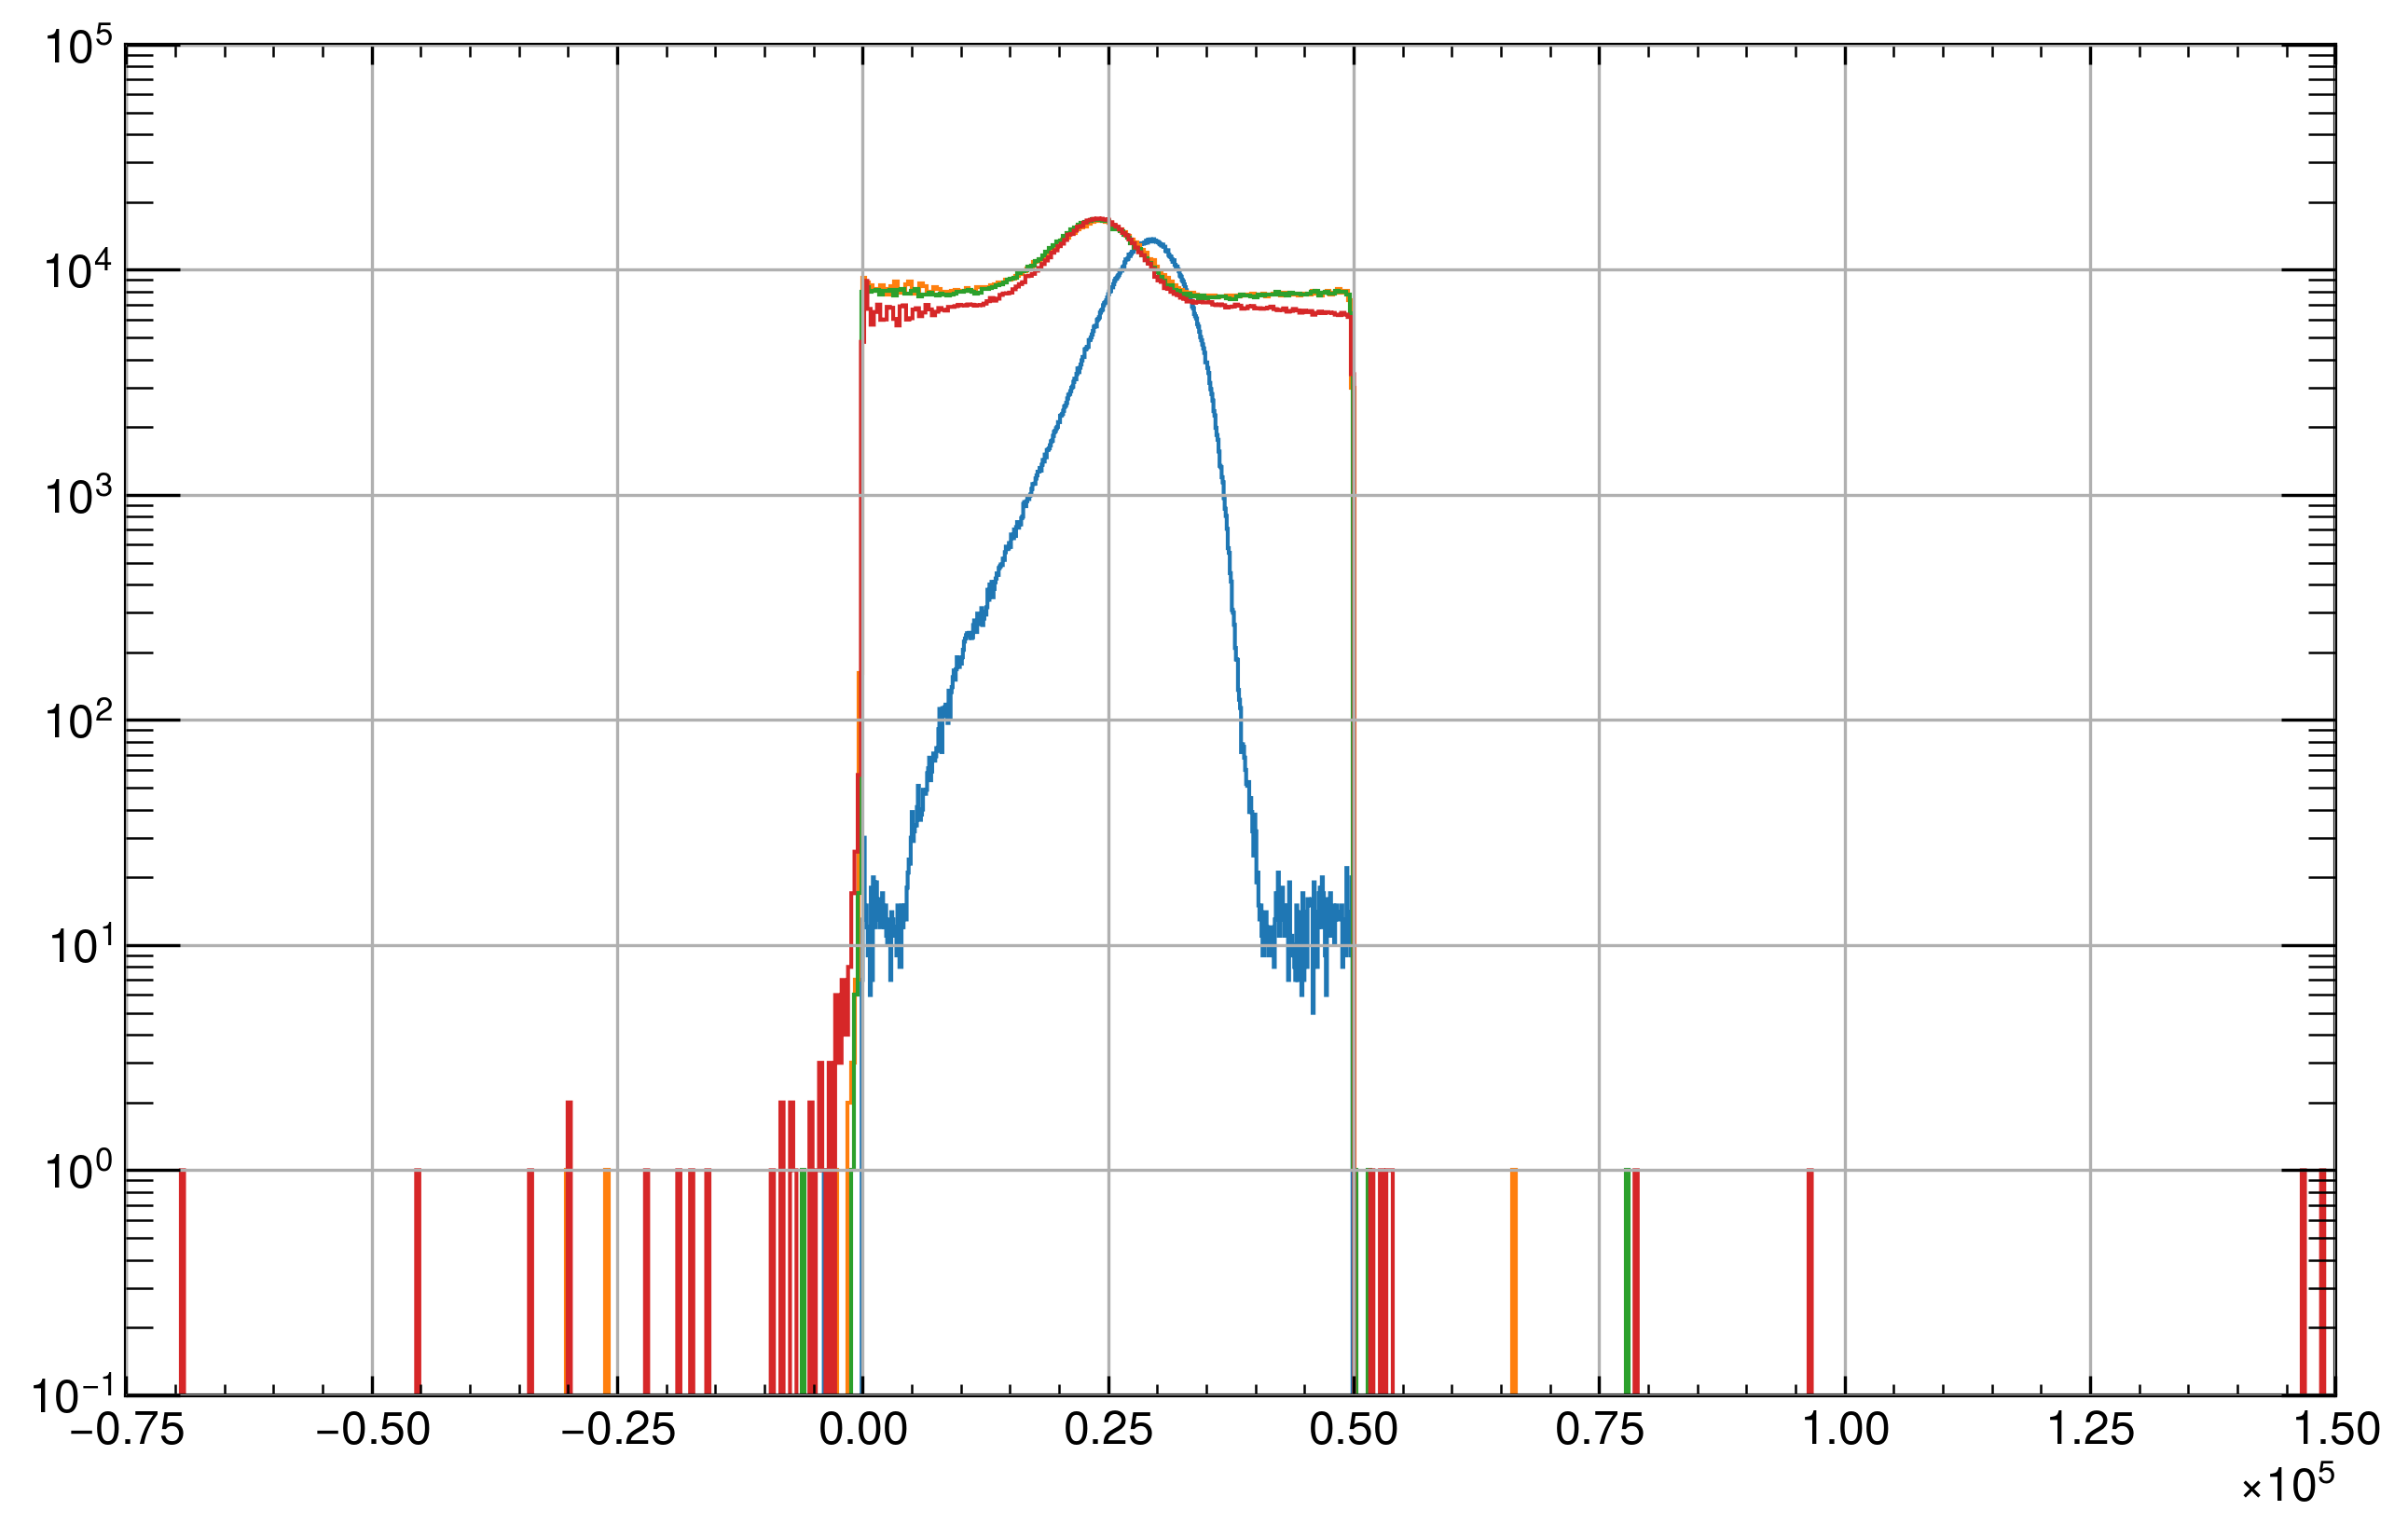

In [70]:
_,_,_,fig,ax = plot_histogram(df[this_scope]["timeCFD50_0"], label="0")
plot_histogram(df[this_scope]["timeCFD50_1"], fig_ax=(fig,ax), label="1")
plot_histogram(df[this_scope]["timeCFD50_2"], fig_ax=(fig,ax), label="2")
plot_histogram(df[this_scope]["timeCFD50_3"], fig_ax=(fig,ax), label="3")
ax.semilogy();

### Charge plot with different cuts
(for one DUT)

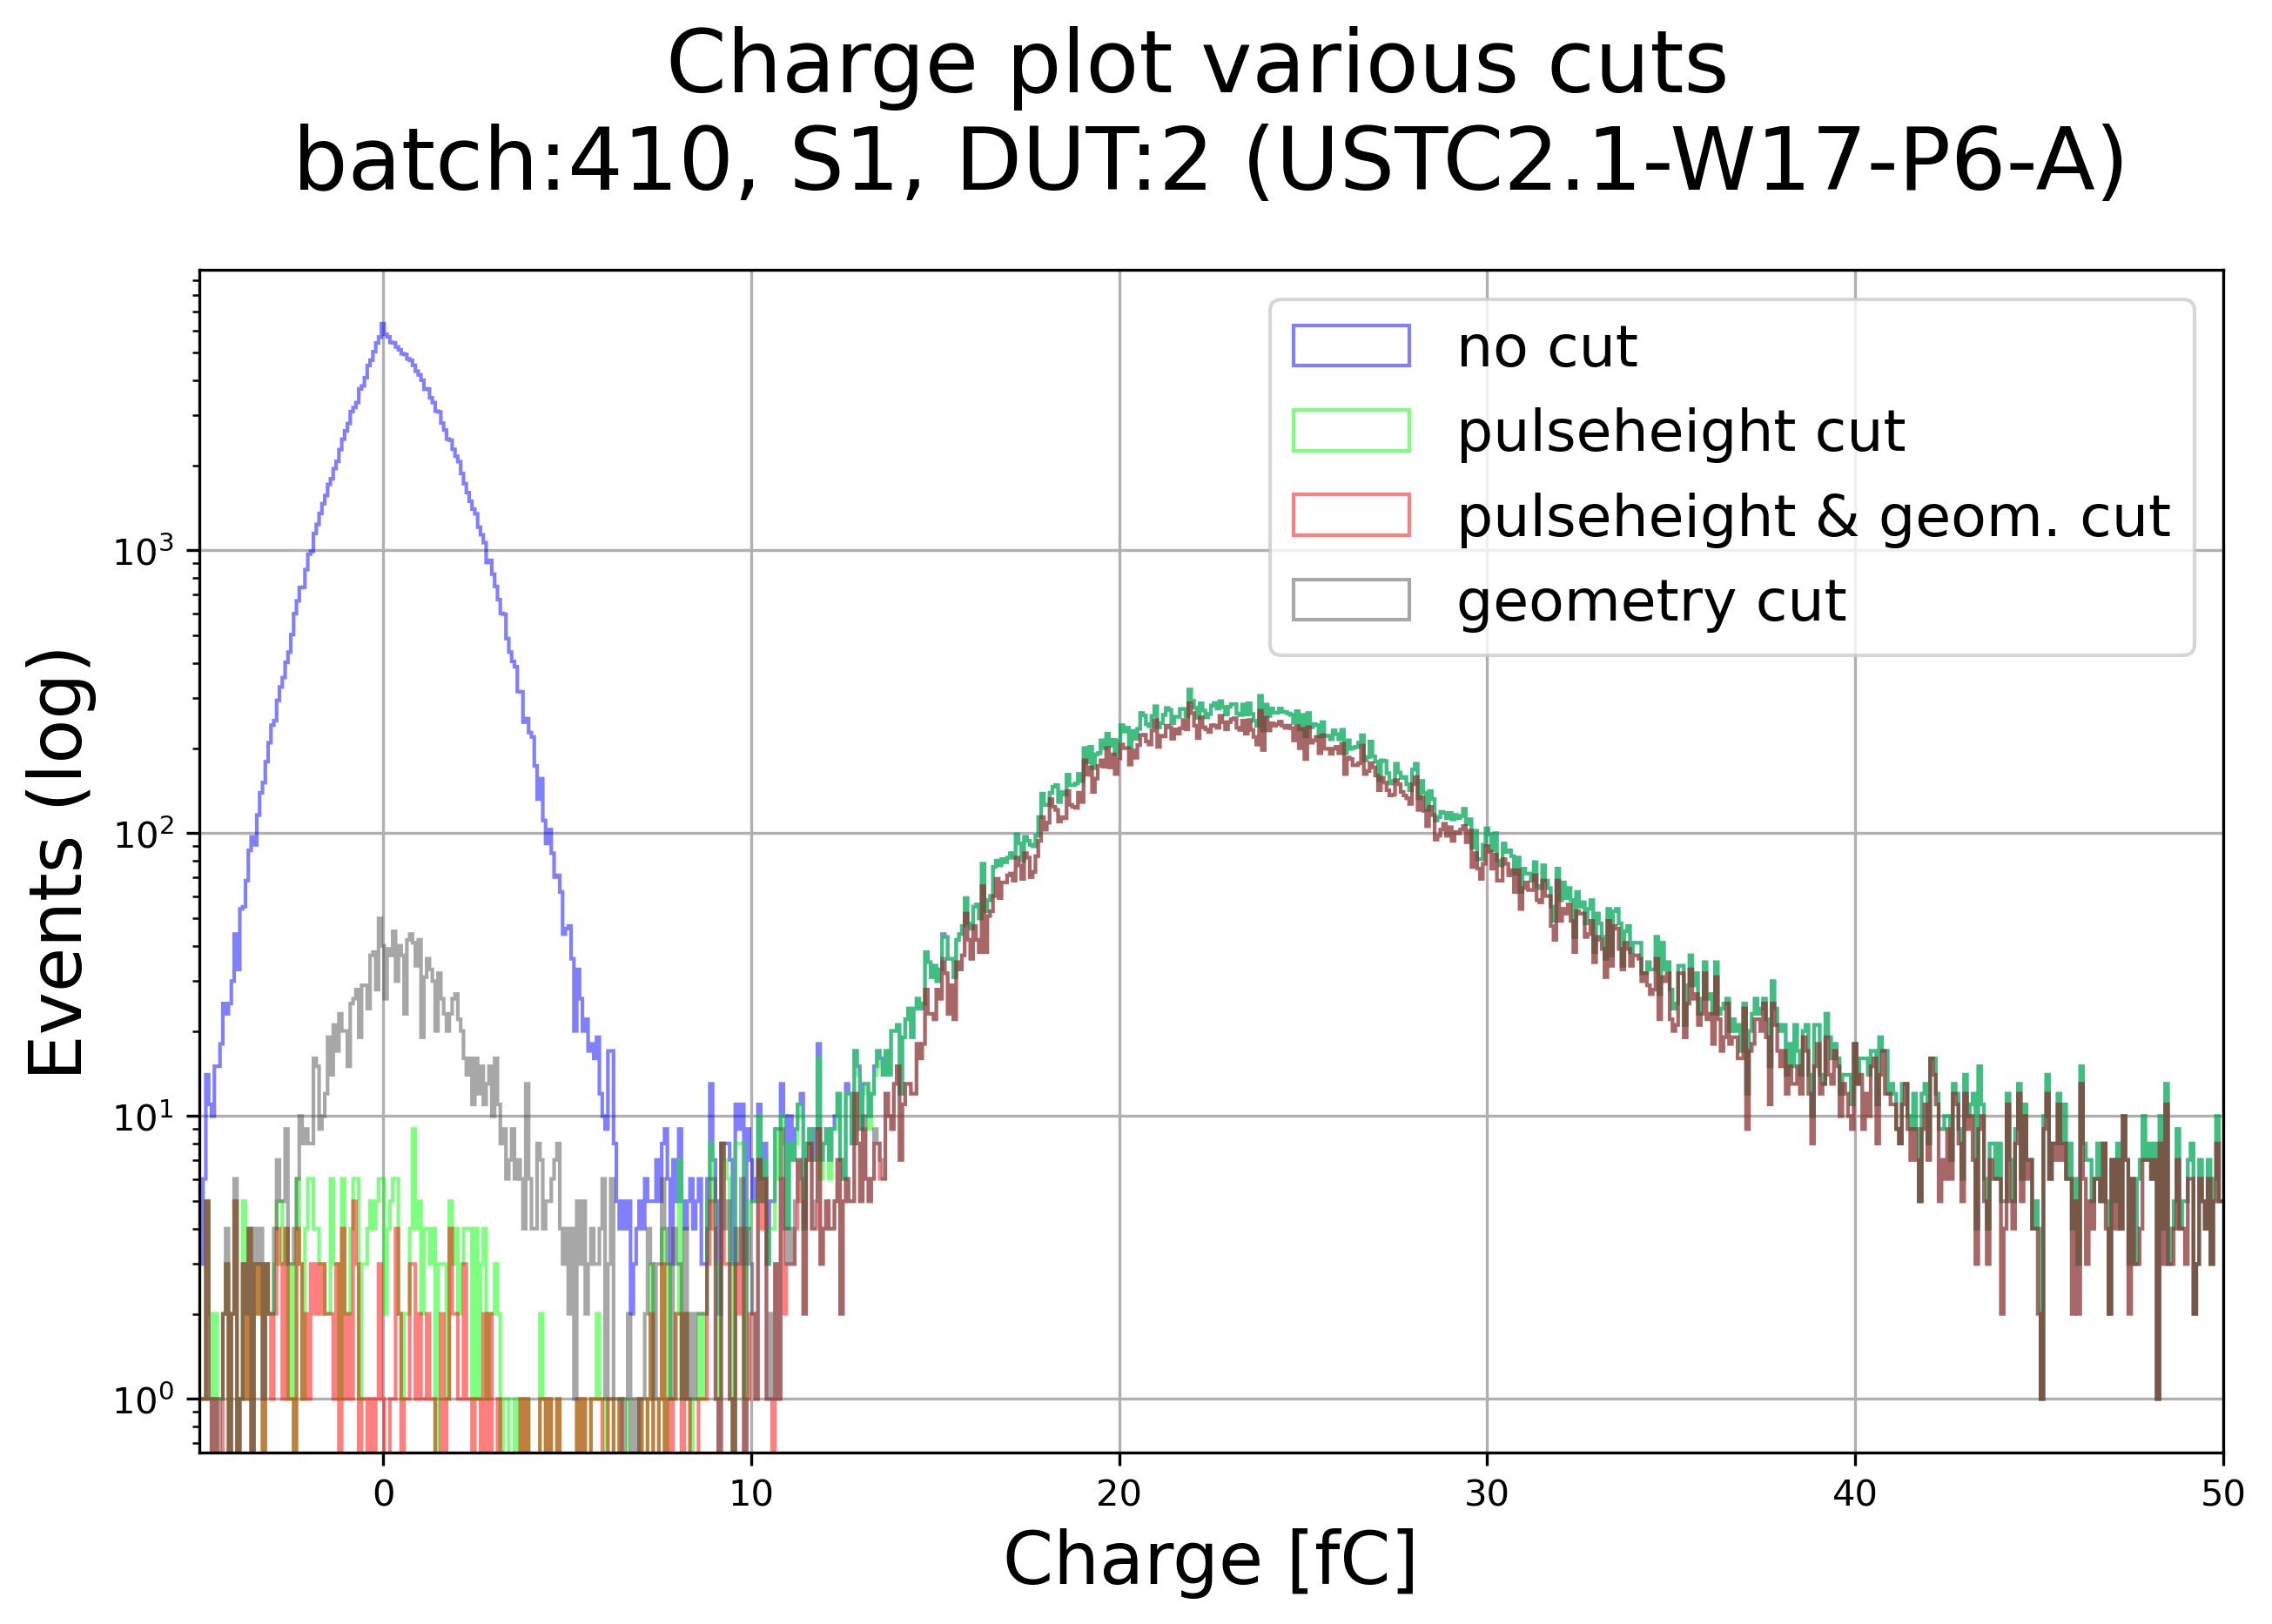

In [30]:
# mins = {"S1":[0,53.8,52.1,65.3], "S2":[0,37.9,51.6,64.3]}
this_scope = "S1"
this_DUT = 2 ### 1,2,3
transimpedance = 4700

pulseheight_cut = df[this_scope][f"pulseHeight_{this_DUT}"]>mins[this_scope][this_DUT]
geometry_cut = geometry_mask(df[this_scope], bins=bins, bins_find_min='rice', DUT_number=this_DUT)

data_pulse_filter = df[this_scope][f"charge_{this_DUT}"].loc[pulseheight_cut]/transimpedance
data_pulse_geo_filter = df[this_scope][f"charge_{this_DUT}"].loc[np.logical_and(pulseheight_cut, geometry_cut)]/transimpedance
data_geo_filter = df[this_scope][f"charge_{this_DUT}"].loc[geometry_cut]/transimpedance

# I need to figure out how to combine colors into nice thing
fig, ax = plt.subplots(figsize=(10,6), dpi=300)
hist, bins_for_all, _,_,_ = plot_histogram(df[this_scope][f"charge_{this_DUT}"]/transimpedance, bins='auto', label="no cut", fig_ax=(fig,ax), alpha=.5, color='#0000ff')
plot_histogram(data_pulse_filter, bins=bins_for_all, fig_ax=(fig,ax), label="pulseheight cut", alpha=.5, color='#00ff00')
plot_histogram(data_pulse_geo_filter, bins=bins_for_all, fig_ax=(fig,ax), label="pulseheight & geom. cut", alpha=.5, color='#ff0000')
plot_histogram(data_geo_filter, bins=bins_for_all, fig_ax=(fig,ax), label="geometry cut", alpha=.5, color='#505050') # #ffff00
ax.set_xlabel("Charge [fC]", fontsize=20)
ax.set_ylabel("Events (log)", fontsize=20)
ax.set_title(f"Charge plot various cuts \nbatch:{this_batch}, {this_scope}, DUT:{this_DUT} ({sensors_list[this_batch][this_scope][f'Ch{this_DUT+1}']})",
             fontsize=24,y=1.05)
ax.grid('--')
ax.set_xlim(-5,50)
ax.semilogy()
ax.legend(fontsize=16)

# fig.savefig(f"../various plots/charge_plot_various_cuts_{this_batch}_{this_scope}_DUT{this_DUT}.jpg")

In [ ]:
dict_mins

In [ ]:
fig, ax = plt.subplots(figsize=(14,8))
# ax.axvline(x=charge_threshold, color='r', label=f'threshold charge: {charge_threshold}fC')
charge_hist, bins_hist, _ = ax.hist(df[this_scope]["charge_1"].iloc[np.where(
    geometry_1.combine(filter_1, my_and))]/transimpedance,
                                    bins='auto', histtype='step', label='Charge Histogram')
bins_centers = (bins_hist[1:]+bins_hist[:-1])/2
bins_centers = bins_centers.astype(np.float64)

param, covariance = curve_fit(pylandau.langau, bins_centers, charge_hist, p0=(10,1,1,4000))
# print(param)
ax.plot(bins_centers, pylandau.langau(bins_centers, *param), label="Landau*Gaussian fit")
ax.semilogy()
ax.set_xlim(-10, 50)
ax.set_ylim(0.1,1e6)
ax.set_xlabel("Charge [fC]", fontsize=20)
ax.set_ylabel("Events", fontsize=20)
ax.set_title(f"Charge distribution and Landau*Gaussian fit, Ch2", fontsize=24, y=1.05)
ax.grid('--')
legend_text = "MPV: %.2f, $\eta$: %.2f, $\sigma$: %.2f" %(param[0],param[1], param[2]) # only two decimals
handles, labels = ax.get_legend_handles_labels()
handles.append(mpatches.Patch(color='none', label=legend_text))
ax.legend(handles=handles, fontsize=20);
fig.savefig(f"../various plots/Charge_distribution_fit_Ch2_{this_batch}.jpg")

In [ ]:
covariance[0,0]**(1/2)

#### I was trying to plot the FE-I4 mask but it does not quite work

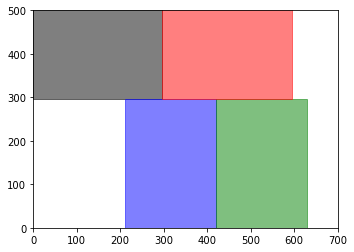

In [65]:
# ### I was trying to plot the FE-I4 mask but it does not quite work

# ### Create a figure and axis
# fig, ax = plt.subplots()
# ### Define the coordinates, width, and height of multiple rectangles
# rectangles = [#(0,0,210,297), # x,y,width, height
#               (0,297,297,210),
#               (210,0,210,297),
#               (420,0,210,297),
#               (297,297,297,210)]

# ### Loop through the list of rectangles and draw them
# for i, rect in enumerate(rectangles):
#     x, y, width, height = rect
#     ax.add_patch(mpatches.Rectangle((x, y), width, height, fill=True, alpha=0.5, color=colormap[i]))

# ### Set axis limits if needed
# ax.set_xlim(0,700)
# ax.set_ylim(0,500)

# ### Display the plot
# plt.gca().set_aspect('equal', adjustable='box')  # Make sure aspect ratio is equal
# plt.show()